# Colab Setup

This notebook requires a GPU runtime.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%%bash

#git clone https://github.com/explanare/ravel.git
#git clone https://github.com/stanfordnlp/pyvene.git

#pip install accelerate
#pip install datasets

# cd pyvene
# git checkout d29f9591ca61753d66ba25f6cc3a4c05bab48480

In [3]:
import numpy as np
import random
import sys
import torch

import numpy as np
import random
import torch
import torch.nn as nn
import pyvene as pv

import accelerate
from huggingface_hub import hf_hub_download

RAVEL_LIB_DIR = 'src'
RAVEL_SCRIPT_DIR = 'scripts'
PYVENE_LIB_DIR = 'pyvene'

sys.path.append(RAVEL_LIB_DIR)
sys.path.append(RAVEL_SCRIPT_DIR)
sys.path.append(PYVENE_LIB_DIR)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(0)

device = "cpu"
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"

#!mkdir models
#!mkdir data

MODEL_DIR = 'models'
DATA_DIR = 'data'

In [4]:
device = "cpu"
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"

# Model

In [5]:
# from transformers import AutoConfig, LlamaForCausalLM, AutoTokenizer

# model_id = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"

# tokenizer = AutoTokenizer.from_pretrained(model_id, cache_dir=MODEL_DIR)
# model = LlamaForCausalLM.from_pretrained(
#     model_id, low_cpu_mem_usage=True, device_map='auto', cache_dir=MODEL_DIR,
#     torch_dtype=torch.bfloat16)
# model = model.eval()
# tokenizer.pad_token = tokenizer.eos_token
# tokenizer.padding_side = 'left'

# VOCAB = sorted(tokenizer.vocab, key=tokenizer.vocab.get)

In [6]:
# Load model
from transformers import AutoModelForCausalLM, AutoTokenizer

with open('hf_token.txt', 'r') as f:
    hf_token = f.read().strip()

model_id = "google/gemma-2-2b"
model_name = "gemma-2-2b"

torch.set_grad_enabled(False) # avoid blowing up mem
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    cache_dir=MODEL_DIR,
    token=hf_token,
    device_map=device,
    low_cpu_mem_usage=True,
    attn_implementation="eager"
)

tokenizer =  AutoTokenizer.from_pretrained(
    model_id,
    cache_dir=MODEL_DIR,
    token=hf_token,
)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'
VOCAB = sorted(tokenizer.vocab, key=tokenizer.vocab.get)

layer_idx = 18

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
from nnsight import NNsight
nnsight_model = NNsight(model)
nnsight_tracer_kwargs = {'scan': True, 'validate': False, 'use_cache': False, 'output_attentions': False}

# Dataset

**Download the RAVEL-TinyLlama instance (tinyllama.tgz) from [Google Drive](https://drive.google.com/file/d/1Vyet8flNLiL_nOKTy-BsDCr35zX730Ol/view?usp=sharing)**. The instance contains four files:

* Training data for DAS & MDAS: [`tinyllama_city_train.json`](https://drive.google.com/file/d/1NWdEjkisvN_1p7fGg7qwgEAQkfJhjSrQ/view?usp=drive_link)

* Entity val/test data: [`tinyllama_city_entity_test.json`](https://drive.google.com/file/d/1kXGuL_Picc4aHuTc2XpyaLBZFaji0bxC/view?usp=drive_link)

* Context val/test data: [`tinyllama_city_context_test.json`](https://drive.google.com/file/d/1c8VPfg4dHDwtej31lB9DFEpI31loBBCb/view?usp=drive_link)

* Intervention locations: [`tinyllama_city_prompt_to_entity_position.json`](https://drive.google.com/file/d/1DtAfnSKMRso7RAphjkp3hMjvFw7HcazB/view?usp=drive_link)


In [8]:
# %%bash

# tar -xzf tinyllama.tgz -C /content/data/
# mkdir data/base
# tar -xvf /content/ravel/data.tgz -C data/base --strip-components=1

In [9]:
import json
import os
import random

import datasets
from datasets import Dataset


instance = model_name
entity_type = 'city'
INPUT_MAX_LEN = 48
FEATURE_TYPES = datasets.Features({"input": datasets.Value("string"), "label": datasets.Value("string"),
                              "source_input": datasets.Value("string"), "source_label": datasets.Value("string"),
                              "inv_label": datasets.Value("string"),
                              'split': datasets.Value("string"), 'source_split': datasets.Value("string"),
                              'entity': datasets.Value("string"), 'source_entity': datasets.Value("string")})


# Load training dataset.
split_to_raw_example = json.load(open(os.path.join(DATA_DIR, f'{instance}/{instance}_{entity_type}_train.json'), 'r'))
# Load validation + test dataset.
split_to_raw_example.update(json.load(open(os.path.join(DATA_DIR, f'{instance}/{instance}_{entity_type}_context_test.json'), 'r')))
split_to_raw_example.update(json.load(open(os.path.join(DATA_DIR, f'{instance}/{instance}_{entity_type}_entity_test.json'), 'r')))
# Prepend an extra token to avoid tokenization changes for Llama tokenizer.
# Each sequence will start with <s> _ 0
SOS_PAD = '0'
NUM_SOS_TOKENS = 3
for split in split_to_raw_example:
  for i in range(len(split_to_raw_example[split])):
    split_to_raw_example[split][i]['inv_label'] = SOS_PAD + split_to_raw_example[split][i]['inv_label']
    split_to_raw_example[split][i]['label'] = SOS_PAD + split_to_raw_example[split][i]['label']


# Load attributes (tasks) to prompt mapping.
ALL_ATTR_TO_PROMPTS = json.load(open(os.path.join(DATA_DIR, 'base', f'ravel_{entity_type}_attribute_to_prompts.json')))

# Load prompt to intervention location mapping.
split_to_entity_pos = json.load(open(os.path.join(DATA_DIR, instance, f'{instance}_{entity_type}_prompt_to_entity_position.json')))
SPLIT_TO_INV_LOCATIONS = {
    f'{task}{split}': {'max_input_length': INPUT_MAX_LEN,
                       'inv_position': [INPUT_MAX_LEN + pos]}
    for task, pos in split_to_entity_pos.items()
    for split in ('-train', '-test', '-val', '')
}
assert(min([min(v['inv_position']) for v in SPLIT_TO_INV_LOCATIONS.values()]) > 0)


# Preprocess the dataset.
def filter_inv_example(example):
  return (example['label'] != example['inv_label'] and
          example['source_split'] in SPLIT_TO_INV_LOCATIONS and
          example['split'] in SPLIT_TO_INV_LOCATIONS)

for split in split_to_raw_example:
  random.shuffle(split_to_raw_example[split])
  split_to_raw_example[split] = list(filter(filter_inv_example, split_to_raw_example[split]))
  if len(split_to_raw_example[split]) == 0:
    print('Empty split: "%s"' % split)
# Remove empty splits.
split_to_raw_example = {k: v for k, v in split_to_raw_example.items() if len(v) > 0}
print(f"#Training examples={sum(map(len, [v for k, v in split_to_raw_example.items() if k.endswith('-train')]))}, "
      f"#Validation examples={sum(map(len, [v for k, v in split_to_raw_example.items() if k.endswith('-val')]))}, "
      f"#Test examples={sum(map(len, [v for k, v in split_to_raw_example.items() if k.endswith('-test')]))}")
split_to_dataset = {split: Dataset.from_list(
    split_to_raw_example[split], features=FEATURE_TYPES)
                    for split in split_to_raw_example}

# #Training examples=116728, #Validation examples=20516, #Test examples=22497

#Training examples=9984, #Validation examples=870, #Test examples=891


# Sparse Autoencoder (SAE)

## Training

We will train a sparse autoencoder on entity representations extracted offline.

* Download entity representations extracted from the Wikipedia dataset [here](https://drive.google.com/file/d/1hZ-Nv3ehf0Ok4ic3ybe-DATEh-HRjYkt/view?usp=drive_link)

In [10]:
# from src.utils.dataset_utils import HDF5Dataset


# file_path = os.path.join(DATA_DIR, "wikipedia_20220301_city_tinyllama_layer14_features_200k.hdf5")
# TRAINING_BATCH_SIZE = 32
# train_dataset = HDF5Dataset(file_path, sample_range=None)
# val_dataset = HDF5Dataset(file_path, sample_range=list(range(80, 128)))
# wiki_train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAINING_BATCH_SIZE, shuffle=True)
# wiki_val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=TRAINING_BATCH_SIZE, shuffle=True)

In [11]:
# task_name = 'tinyllama-layer14-dim8192-reg0.5-ep5-sae-city_wikipedia_200k' #@param
# task_name

In [12]:
# from train_sae import train_sae


# config = {
#     'task_name': task_name,
#     'reg_coeff': float(re.search('reg([\d.]+)', task_name).group(1)),
#     'input_dim': model.config.hidden_size,
#     'latent_dim': int(re.search('dim(\d+)', task_name).group(1)),
#     'learning_rate': 1e-4,
#     'weight_decay': 1e-4,
#     'end_learning_rate_ratio': 0.5,
#     'num_epochs': int(re.search('ep(\d+)', task_name).group(1)),
#     'model_dir': MODEL_DIR,
#     'log_dir': os.path.join(MODEL_DIR, 'logs', task_name),
# }

# # Training metrics are logged to the Tensorboard at http://localhost:6006/.
# autoencoder = train_sae(config, wiki_train_dataloader, wiki_val_dataloader)

## Gemma 2 2B SAE Setup

In [13]:
sae_repo_id = "google/gemma-scope-2b-pt-res"
# sae_filename = "layer_20/width_16k/average_l0_71/params.npz"
#sae_filename = "layer_14/width_16k/average_l0_43/params.npz"
#sae_filename = "layer_10/width_16k/average_l0_77/params.npz"
sae_filename = "layer_18/width_16k/average_l0_74/params.npz"

layer_idx = 18

autoencoder_run_name = (sae_repo_id + '-' + sae_filename.replace('/', '-')).replace('.npz', '')

path_to_params = hf_hub_download(
    repo_id=sae_repo_id,
    filename=sae_filename,
    force_download=False,
    cache_dir= os.path.join(MODEL_DIR, model_name),
)
params = np.load(path_to_params)
pt_params = {k: torch.from_numpy(v).to(device) for k, v in params.items()}



class JumpReluAutoEncoder(torch.nn.Module):
    """Sparse Autoencoder with a two-layer encoder and a two-layer decoder."""

    def __init__(self, embed_dim, latent_dim, device):
        super().__init__()
        self.dtype = torch.float32
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.W_enc = nn.Parameter(torch.empty(embed_dim, latent_dim))
        self.b_enc = nn.Parameter(torch.zeros(latent_dim))
        self.W_dec = nn.Parameter(torch.empty(latent_dim, embed_dim))
        self.b_dec = nn.Parameter(torch.zeros(embed_dim))
        self.threshold = nn.Parameter(torch.zeros(latent_dim))
        self.autoencoder_losses = {}

    def encode(self, x, normalize_input=False):
        if normalize_input:
            raise ValueError("Not supported")
            x = x - self.decoder[0].bias
        pre_jump = x @ self.W_enc + self.b_enc

        f = nn.ReLU()(pre_jump * (pre_jump > self.threshold))
        # Decoder weights are not normalized. Thus we have to compensate here to get comparabe feature activations.
        f = f * self.W_dec.norm(dim=1)
        return f

    def decode(self, z):
        # Decoder weights are not normalized. Thus we have to compensate here to get comparabe feature activations.
        z = z / self.W_dec.norm(dim=1)
        return z @ self.W_dec + self.b_dec

    def forward(self, base):
        base_type = base.dtype
        base = base.to(self.dtype)
        self.autoencoder_losses.clear()
        z = self.encode(base)
        base_reconstruct = self.decode(z)
        # The sparsity objective.
        l1_loss = torch.nn.functional.l1_loss(z, torch.zeros_like(z))
        # The reconstruction objective.
        l2_loss = torch.mean((base_reconstruct - base)**2)
        self.autoencoder_losses['l1_loss'] = l1_loss
        self.autoencoder_losses['l2_loss'] = l2_loss
        return {'latent': z, 'output': base_reconstruct.to(base_type)}

    def get_autoencoder_losses(self):
        return self.autoencoder_losses

    @classmethod
    def from_pretrained(
        cls,
        path: str | None = None, 
        load_from_sae_lens: bool = False,
        device: torch.device | None = None,
        **kwargs,
    ):
        """
        Load a pretrained autoencoder from a file.
        If sae_lens=True, then pass **kwargs to sae_lens's
        loading function.
        """
        state_dict = torch.load(path)
        latent_dim, embed_dim = state_dict['W_enc'].shape
        autoencoder = cls(embed_dim, latent_dim, device)
        autoencoder.load_state_dict(state_dict)



embed_dim = params['W_enc'].shape[0]
latent_dim = params['W_enc'].shape[1]

sae = JumpReluAutoEncoder(
    embed_dim=embed_dim,
    latent_dim=latent_dim,
    device=device,
)
sae.load_state_dict(pt_params)
sae.to(device)

autoencoder = sae

## Feature Selection

In [14]:
# autoencoder_run_name = 'tinyllama-layer14-dim8192-reg0.5-ep5-sae-city_wikipedia_200k.pt'
# autoencoder = torch.load(os.path.join(MODEL_DIR, autoencoder_run_name)).to(device)

In [15]:
# Load the RAVEL dataset.
import json

from src.utils.dataset_utils import load_selected_entity_representation_with_label


entity_type = 'city'
layer = 18
print(entity_type, layer)

model_type = model_name
splits = ['train', 'val_entity', 'val_context']
feature_hdf5_path = os.path.join(DATA_DIR, f'ravel_{entity_type}_{model_type}_layer{layer}_representation.hdf5')
entity_attr_to_label = json.load(open(os.path.join(DATA_DIR, 'base', f'ravel_{entity_type}_entity_attributes.json')))
X, Y, sorted_unique_label = load_selected_entity_representation_with_label(feature_hdf5_path, entity_attr_to_label, splits, ["Country"])

city 18
#unique labels=89 ['Albania', 'Angola', 'Argentina', 'Australia', 'Bangladesh', 'Belarus', 'Belize', 'Benin', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria', 'Cameroon', 'Canada', 'Chile', 'China', 'Colombia', 'Croatia', 'Cuba', 'Cyprus', 'Denmark', 'Egypt', 'Estonia', 'Finland', 'France', 'Germany', 'Greenland', 'Guinea', 'Guyana', 'Honduras', 'Hungary', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Italy', 'Japan', 'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Lithuania', 'Madagascar', 'Malawi', 'Malaysia', 'Mali', 'Mexico', 'Mongolia', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia', 'New Zealand', 'Nicaragua', 'Niger', 'Nigeria', 'Norway', 'Pakistan', 'Papua New Guinea', 'Peru', 'Poland', 'Portugal', 'Romania', 'Russia', 'Senegal', 'Sierra Leone', 'South Africa', 'South Korea', 'South Sudan', 'Spain', 'Sri Lanka', 'Sudan', 'Swaziland', 'Sweden', 'Switzerland', 'Syria', 'Taiwan', 'Tanzania', 'Thailand', 'Turkey', 'Uganda', 'Ukraine', 'Uzbekistan', 'Venezu

In [16]:
# Run feature selection.
import numpy as np

from src.methods.select_features import select_features_with_classifier

intervention_dim_to_eval = [
    ('reconstruction', None),
    ('dim%d' % autoencoder.latent_dim, range(autoencoder.latent_dim))]

attr = 'Country'
coeff_to_kept_dims = select_features_with_classifier(
    autoencoder.encode, torch.from_numpy(X[attr]['train']).to(device), Y[attr]['train'])
for kept_dim in coeff_to_kept_dims.values():
  intervention_dim_to_eval.append(('dim%d' % len(kept_dim), kept_dim))
# Random baselines.
for i in [64, 512]:
    kept_dim = np.random.permutation(autoencoder.latent_dim)[:i]
    intervention_dim_to_eval.append(('random_dim%d' % len(kept_dim), kept_dim))

## Evaluation

In [17]:
# # # Run eval
# import re

# from src.utils.intervention_utils import load_intervenable_with_autoencoder, eval_with_interventions, remove_all_forward_hooks
# from src.utils.metric_utils import compute_metrics

# eval_split_to_dataset = {k: v for k, v in split_to_dataset.items()
#                          if k.endswith('-test') or k.endswith('-val')
#                          }

# target_task = 'Country'
# max_new_tokens = 3
# layer = int(re.search(r'layer(\d+)', autoencoder_run_name).group(1))
# print(f'Layer={layer}')

# for inv_name, inv_dims in intervention_dim_to_eval:
#   if inv_name == 'reconstruction':
#     continue
#   intervenable = load_intervenable_with_autoencoder(model, autoencoder, inv_dims, layer)
#   intervenable.set_device("cuda")
#   intervenable.disable_model_gradients()
#   split_to_eval_metrics = eval_with_interventions(
#       intervenable, eval_split_to_dataset, SPLIT_TO_INV_LOCATIONS, tokenizer,
#       max_new_tokens=max_new_tokens,
#       compute_metrics_fn=compute_metrics,
#       eval_batch_size=128,
#       debug_print=False)
#   json.dump(split_to_eval_metrics, open(os.path.join(MODEL_DIR, f'{autoencoder_run_name.split(".pt")[0]}_{inv_name}_{max_new_tokens}tok_{target_task}.json'), 'w'))
#   remove_all_forward_hooks(intervenable)
#   del intervenable

In [18]:
eval_split_to_dataset = {k: v for k, v in split_to_dataset.items()
                         if k.endswith('-test') or k.endswith('-val')
                         }
print(len(eval_split_to_dataset))

8


In [19]:
from src.utils.updated_intervention_utils import nnsight_intervention, eval_with_interventions

batch_size = 2
intervention_dims = range(autoencoder.latent_dim)
base_promts  = ['Paris is in the country of', 'The main language spoken in the city of London is']
source_prompts = ['Tokyo is big.', 'Berlin is exciting.']
n_generated_tokens = 3
add_reconstruction_error = True

base_tok = tokenizer(base_promts, return_tensors='pt', padding="max_length", truncation=True, max_length=INPUT_MAX_LEN)
source_tok = tokenizer(source_prompts, return_tensors='pt', padding="max_length", truncation=True, max_length=INPUT_MAX_LEN)
base_tok = model.prepare_inputs_for_generation(**base_tok)
source_tok = model.prepare_inputs_for_generation(**source_tok)
base_inv_pos = torch.ones(batch_size, device=device, dtype=torch.int) * -1
source_inv_pos = torch.ones(batch_size, device=device, dtype=torch.int) * -1
base_inv_pos = torch.tensor([[42], [46]], dtype=torch.int)

# # Tinyllama
# source_inv_pos = torch.tensor([[44], [43]], dtype=torch.int)

# Gemma2-2b
source_inv_pos = torch.tensor([[44], [44]], dtype=torch.int)

# print(f'base_inv_pos: {base_inv_pos}')
# print(f'source_inv_pos: {source_inv_pos}')

# for tok_ids in source_tok['input_ids']:
#     for j, tok in enumerate(tok_ids):
#         print(f'{j}, tok: {tokenizer.decode(tok)}')


# for i in torch.arange(1, len(base_tok['input_ids'][0]), device=device, dtype=torch.int) * -1:
    # if i == 10:
    #         break
#     print(f'i: {i}')
#     base_inv_pos = torch.tensor([[i]])
print(f'prompt1 base_token decoded: {tokenizer.decode(base_tok["input_ids"][0][base_inv_pos[0][0]])}')
print(f'prompt1 source_token decoded: {tokenizer.decode(source_tok["input_ids"][0][source_inv_pos[0][0]])}')
print(f'prompt2 base_token decoded: {tokenizer.decode(base_tok["input_ids"][1][base_inv_pos[1][0]])}')
print(f'prompt2 source_token decoded: {tokenizer.decode(source_tok["input_ids"][1][source_inv_pos[1][0]])}')

inputs = {
    'input_ids': base_tok['input_ids'].to(device),
    'attention_mask': base_tok['attention_mask'].to(device),
    'position_ids': base_tok['position_ids'].to(device),
    'source_input_ids': source_tok['input_ids'].to(device),
    'source_attention_mask': source_tok['attention_mask'].to(device),
    'source_position_ids': source_tok['position_ids'].to(device),
}


counterfactual_out_tokens = nnsight_intervention(
    nnsight_model,
    nnsight_tracer_kwargs,
    layer_idx,
    autoencoder,
    intervention_dims,
    inputs,
    None, #split_to_inv_locations is not used in the test
    n_generated_tokens,
    device,
    tokenizer,
    add_reconstruction_error,
    inv_positions=(base_inv_pos, source_inv_pos),
    verbose=True
    )
    

prompt1 base_token decoded: Paris
prompt1 source_token decoded: Tokyo
prompt2 base_token decoded:  London
prompt2 source_token decoded: Berlin
counterfactual_out_tokens decoded: ['Paris is in the country of France', 'The main language spoken in the city of London is English']
counterfactual_out_tokens decoded: ['Paris is in the country of France.', 'The main language spoken in the city of London is English.']
counterfactual_out_tokens decoded: ['Paris is in the country of France. It', 'The main language spoken in the city of London is English. However']


In [20]:
def compute_metrics(tokenizer, eval_preds, eval_labels, pad_token_id, last_n_tokens=1, **kwargs):
    """Computes squence-level and token-level accuracy."""
    total_count, total_token_count = 0, 0
    correct_count, correct_token_count = 0, 0
    for eval_pred, eval_label in zip(eval_preds, eval_labels):
        actual_test_labels = eval_label[:, -last_n_tokens:]
        if len(eval_pred.shape) == 3:
            # eval_preds is in the form of logits.
            pred_test_labels = torch.argmax(eval_pred[:, -last_n_tokens:], dim=-1)
        else:
            # eval_preds is in the form of token ids.
            pred_test_labels = eval_pred[:, -last_n_tokens:]
        padding_tokens = torch.logical_or(
            actual_test_labels == pad_token_id, actual_test_labels < 0
        )
        match_tokens = actual_test_labels == pred_test_labels
        correct_labels = torch.logical_or(match_tokens, padding_tokens)
        total_count += len(correct_labels)
        correct_count += torch.all(correct_labels, axis=-1).float().sum().tolist()
        total_token_count += (~padding_tokens).float().sum().tolist()
        correct_token_count += (~padding_tokens & match_tokens).float().sum().tolist()
    accuracy = round(correct_count / total_count, 2)
    token_accuracy = round(correct_token_count / total_token_count, 2)
    return {"accuracy": accuracy, "token_accuracy": token_accuracy}

def compute_metrics_string_matching(tokenizer, eval_preds, eval_labels, last_n_tokens, **kwargs):
    """Computes squence-level and string-level accuracy."""
    total_count = 0
    correct_count = 0

    eval_preds = torch.cat(eval_preds, dim=0)
    eval_labels = torch.cat(eval_labels, dim=0)[:, -last_n_tokens:]
    eval_preds_str = tokenizer.batch_decode(eval_preds, skip_special_tokens=True)
    eval_labels_str = tokenizer.batch_decode(eval_labels, skip_special_tokens=True)
    eval_labels_str = [l[1:].strip() for l in eval_labels_str]

    for p, l in zip(eval_preds_str, eval_labels_str):
        # print(f'p: {p}, l: {l}')
        total_count += 1
        if l.lower() in p.lower():
            correct_count += 1

    accuracy = round(correct_count / total_count, 2)
    return {"accuracy": accuracy}   

In [21]:
next(iter(eval_split_to_dataset['city: %s, country:-val']))

{'input': 'city: Mocuba, country:',
 'label': '0 Mozambique',
 'source_input': 'in the city. Duisburg also',
 'source_label': ' has a large number of industrial companies',
 'inv_label': '0 Germany',
 'split': 'city: %s, country:',
 'source_split': 'in the city. %s also',
 'entity': 'Mocuba',
 'source_entity': 'Duisburg'}

In [24]:
import re
# replace slashes with underscores
autoencoder_run_name_clean = re.sub(r'/', '_', autoencoder_run_name)

In [25]:
use_nnsight_replication = True

# Run eval
import re

eval_split_to_dataset = {k: v for k, v in split_to_dataset.items()
                         if k.endswith('-test') or k.endswith('-val')
                         }

target_task = 'Country'
max_new_tokens = 3
print(f'Layer={layer_idx}')

for inv_name, inv_dims in intervention_dim_to_eval:
  if inv_name == 'reconstruction':
    continue
  print(f'Intervention_dims={inv_dims}')
  split_to_eval_metrics = eval_with_interventions(
    hf_model=model,
    nnsight_model=nnsight_model,
    nnsight_tracer_kwargs=nnsight_tracer_kwargs,
    split_to_dataset=eval_split_to_dataset,
    split_to_inv_locations=SPLIT_TO_INV_LOCATIONS,
    tokenizer=tokenizer,
    max_new_tokens=max_new_tokens,
    inv_dims=inv_dims,
    compute_metrics_fn=compute_metrics_string_matching,
    autoencoder=autoencoder,
    layer_idx=layer_idx,
    eval_batch_size=64, # batchsize=32 yields 21GB RAM usage with RTX A6000
    debug_print=False,
    use_nnsight_replication=use_nnsight_replication,
    device=device,
  )
  json.dump(split_to_eval_metrics, open(os.path.join(MODEL_DIR, f'{autoencoder_run_name_clean.split(".pt")[0]}_{inv_name}_{max_new_tokens}tok_{target_task}.json'), 'w'))

Layer=18
Intervention_dims=range(0, 16384)


  0%|          | 0/8 [00:00<?, ?it/s]

Map:   0%|          | 0/362 [00:00<?, ? examples/s]

Map:   0%|          | 0/362 [00:00<?, ? examples/s]

64
64
64
64
64
42


 12%|█▎        | 1/8 [01:05<07:38, 65.43s/it]


 'city: %s, country:-val': {'base_labels': {'accuracy': 0.91}, 'labels': {'accuracy': 0.08}}


Map:   0%|          | 0/368 [00:00<?, ? examples/s]

Map:   0%|          | 0/368 [00:00<?, ? examples/s]

64
64
64
64
64
48


 25%|██▌       | 2/8 [02:16<06:53, 68.85s/it]


 'city to country: Sydney is in Australia. %s is in-test': {'base_labels': {'accuracy': 0.98}, 'labels': {'accuracy': 0.06}}


Map:   0%|          | 0/167 [00:00<?, ? examples/s]

Map:   0%|          | 0/167 [00:00<?, ? examples/s]

64
64
39


 38%|███▊      | 3/8 [02:52<04:28, 53.63s/it]


 'city to country: Tokyo is in Japan. %s is in-test': {'base_labels': {'accuracy': 0.98}, 'labels': {'accuracy': 0.04}}


Map:   0%|          | 0/174 [00:00<?, ? examples/s]

Map:   0%|          | 0/174 [00:00<?, ? examples/s]

64
64
46


 50%|█████     | 4/8 [03:34<03:16, 49.02s/it]


 'city to country: Tokyo is in Japan. %s is in-val': {'base_labels': {'accuracy': 0.99}, 'labels': {'accuracy': 0.01}}


Map:   0%|          | 0/175 [00:00<?, ? examples/s]

Map:   0%|          | 0/175 [00:00<?, ? examples/s]

64
64
47


 62%|██████▎   | 5/8 [04:18<02:22, 47.34s/it]


 'city to country: Toronto is in Canada. %s is in-test': {'base_labels': {'accuracy': 0.98}, 'labels': {'accuracy': 0.03}}


Map:   0%|          | 0/168 [00:00<?, ? examples/s]

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

64
64
40


 75%|███████▌  | 6/8 [05:04<01:34, 47.03s/it]


 'city to country: Toronto is in Canada. %s is in-val': {'base_labels': {'accuracy': 0.99}, 'labels': {'accuracy': 0.02}}


Map:   0%|          | 0/181 [00:00<?, ? examples/s]

Map:   0%|          | 0/181 [00:00<?, ? examples/s]

64
64
53


 88%|████████▊ | 7/8 [05:53<00:47, 47.69s/it]


 'city to country: St. Petersburg is in Russia. %s is in-test': {'base_labels': {'accuracy': 0.99}, 'labels': {'accuracy': 0.03}}


Map:   0%|          | 0/166 [00:00<?, ? examples/s]

Map:   0%|          | 0/166 [00:00<?, ? examples/s]

64
64
38


100%|██████████| 8/8 [06:34<00:00, 49.30s/it]



 'city to country: St. Petersburg is in Russia. %s is in-val': {'base_labels': {'accuracy': 1.0}, 'labels': {'accuracy': 0.04}}
Intervention_dims=[  108   221   232   253   387   448   479   598   753   785   882   900
   921  1223  1269  1297  1439  1450  1466  1467  1474  1506  1570  1645
  1713  1753  1780  1890  1921  2127  2230  2301  2336  2341  2419  2448
  2504  2508  2515  2742  2762  2807  2855  2983  3006  3183  3204  3232
  3314  3347  3376  3383  3409  3533  3554  3572  3629  3639  3656  3825
  3831  3851  3902  3934  4107  4182  4183  4212  4247  4277  4308  4320
  4367  4385  4502  4505  4523  4558  4618  4621  4651  4707  4769  4777
  4825  4875  5008  5049  5062  5199  5313  5338  5343  5384  5486  5540
  5803  5855  5898  5961  6145  6200  6227  6331  6395  6462  6600  6694
  6722  6790  6876  6884  6902  7073  7124  7195  7268  7337  7373  7405
  7430  7474  7477  7535  7598  7607  7618  7660  7840  7845  7863  7868
  7918  8023  8073  8095  8121  8153  8159  8188  

  0%|          | 0/8 [00:00<?, ?it/s]

Map:   0%|          | 0/362 [00:00<?, ? examples/s]

Map:   0%|          | 0/362 [00:00<?, ? examples/s]

64
64
64
64
64
42


 12%|█▎        | 1/8 [01:31<10:43, 91.94s/it]


 'city: %s, country:-val': {'base_labels': {'accuracy': 0.98}, 'labels': {'accuracy': 0.01}}


Map:   0%|          | 0/368 [00:00<?, ? examples/s]

Map:   0%|          | 0/368 [00:00<?, ? examples/s]

64
64
64
64
64
48


 25%|██▌       | 2/8 [03:06<09:21, 93.52s/it]


 'city to country: Sydney is in Australia. %s is in-test': {'base_labels': {'accuracy': 0.98}, 'labels': {'accuracy': 0.05}}


Map:   0%|          | 0/167 [00:00<?, ? examples/s]

Map:   0%|          | 0/167 [00:00<?, ? examples/s]

64
64
39


 38%|███▊      | 3/8 [04:01<06:20, 76.13s/it]


 'city to country: Tokyo is in Japan. %s is in-test': {'base_labels': {'accuracy': 0.99}, 'labels': {'accuracy': 0.03}}


Map:   0%|          | 0/174 [00:00<?, ? examples/s]

Map:   0%|          | 0/174 [00:00<?, ? examples/s]

64
64
46


 50%|█████     | 4/8 [04:57<04:32, 68.09s/it]


 'city to country: Tokyo is in Japan. %s is in-val': {'base_labels': {'accuracy': 0.99}, 'labels': {'accuracy': 0.01}}


Map:   0%|          | 0/175 [00:00<?, ? examples/s]

Map:   0%|          | 0/175 [00:00<?, ? examples/s]

64
64
47


 62%|██████▎   | 5/8 [05:45<03:02, 60.88s/it]


 'city to country: Toronto is in Canada. %s is in-test': {'base_labels': {'accuracy': 0.99}, 'labels': {'accuracy': 0.02}}


Map:   0%|          | 0/168 [00:00<?, ? examples/s]

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

64
64
40


 75%|███████▌  | 6/8 [06:39<01:56, 58.38s/it]


 'city to country: Toronto is in Canada. %s is in-val': {'base_labels': {'accuracy': 1.0}, 'labels': {'accuracy': 0.02}}


Map:   0%|          | 0/181 [00:00<?, ? examples/s]

Map:   0%|          | 0/181 [00:00<?, ? examples/s]

64
64
53


 88%|████████▊ | 7/8 [07:33<00:56, 56.87s/it]


 'city to country: St. Petersburg is in Russia. %s is in-test': {'base_labels': {'accuracy': 0.99}, 'labels': {'accuracy': 0.03}}


Map:   0%|          | 0/166 [00:00<?, ? examples/s]

Map:   0%|          | 0/166 [00:00<?, ? examples/s]

64
64


 88%|████████▊ | 7/8 [07:56<01:08, 68.03s/it]


KeyboardInterrupt: 

# Distributed Alignment Search (DAS/MDAS)

## Training

In [ ]:
import collections
import numpy as np
import re

from datasets import concatenate_datasets
from methods.distributed_alignment_search import LowRankRotatedSpaceIntervention
from methods.differential_binary_masking import DifferentialBinaryMasking
import pyvene as pv
from tqdm import tqdm, trange
from train_intervention import train_intervention
from transformers import get_linear_schedule_with_warmup
from utils.dataset_utils import get_multitask_dataloader
from utils.intervention_utils import train_intervention_step, eval_with_interventions, get_intervention_config, remove_all_forward_hooks, remove_invalid_token_id
from utils.metric_utils import compute_metrics, compute_cross_entropy_loss


def get_short_model_name(model):
  name_match = re.search('(llama-2-\d+b|tinyllama|pythia-[\d.]+b)', model.name_or_path.lower())
  if name_match:
    return name_match.group(1)
  else:
    return model.name_or_path.lower().split('-')[0]


def run_exp(config):
  inv_tasks = '+'.join([''.join(re.findall(r'[A-Za-z]+', t)) for t, l in config['training_tasks'].items() if 'match_source' in l])
  control_tasks = '+'.join([''.join(re.findall(r'[A-Za-z]+', t)) for t, l in config['training_tasks'].items() if 'match_base' in l])
  task_compressed = ((inv_tasks + '_ex_' + control_tasks) if control_tasks else inv_tasks)
  method_name = 'multitask_method' if len(config['training_tasks']) > 1 else 'baseline_method'
  if config['intervenable_config']['intervenable_interventions_type'] == LowRankRotatedSpaceIntervention:
    method_name = method_name.replace('method', 'daslora')
  elif config['intervenable_config']['intervenable_interventions_type'] == DifferentialBinaryMasking:
    if config['regularization_coefficient'] > 1e-6:
      method_name = method_name.replace('method', 'mask_l1')
    else:
      method_name = method_name.replace('method', 'mask')
  split_to_inv_locations = config['split_to_inv_locations']
  input_len = list(split_to_inv_locations.values())[0]['max_input_length']
  inv_pos = min([x['inv_position'][0] for x in split_to_inv_locations.values()])
  inv_loc_name = 'len%d_pos%s' % (input_len, 'e' if inv_pos != input_len - 1 else 'f')
  training_data_percentage = int(config['max_train_percentage'] * 100)
  suffix = f"_cause{config['cause_task_sample_size']}"
  if any([v == 'match_base' for t, v in config['training_tasks'].items()]):
    suffix += f'_iso{config["iso_task_sample_size"]}'
  layer = config['intervenable_config']['intervenable_layer']
  run_name = (f"{get_short_model_name(model)}-layer{layer}"
              f"-dim{config['intervention_dimension']}"
              f"-{method_name}_{config['max_output_tokens']}tok_"
              f"{task_compressed}_{inv_loc_name}_ep{config['training_epoch']}{suffix}")
  config['run_name_prefix'] = run_name.rsplit('_ep', 1)[0]
  print(run_name)
  intervenable, intervenable_config = train_intervention(config, model, tokenizer, split_to_dataset)
  # Save model.
  torch.save({k: v[0].rotate_layer.weight for k, v in intervenable.interventions.items()},
             os.path.join(MODEL_DIR, f'{run_name}.pt'))
  print('Model saved to %s' % os.path.join(MODEL_DIR, f'{run_name}.pt'))
  # Eval.
  split_to_eval_metrics = eval_with_interventions(
      intervenable, eval_split_to_dataset, split_to_inv_locations, tokenizer,
      compute_metrics_fn=compute_metrics,
      max_new_tokens=config['max_output_tokens'],
      eval_batch_size=EVAL_BATCH_SIZE)
  # Logging.
  json.dump(split_to_eval_metrics, open(os.path.join(MODEL_DIR, f'{run_name}_evalall.json'), 'w'))
  print('Saved to %s' % os.path.join(MODEL_DIR, f'{run_name}_evalall.json'))
  remove_all_forward_hooks(intervenable)
  return intervenable


attrs = list(ALL_ATTR_TO_PROMPTS)
target_attr = 'Country'

# Train on disentangling Country attribute only.
training_tasks_list = [
  {t: 'match_source'} for t in attrs if t == target_attr
] + [
    {t: 'match_source' if t == target_t else 'match_base' for t in attrs}
    for target_t in attrs if target_t == target_attr
]

eval_split_to_dataset = {k: v for k, v in split_to_dataset.items()
                         if k.endswith('-test') or k.endswith('-val')}

model = model.eval()

TRAINING_BATCH_SIZE = 16
EVAL_BATCH_SIZE = 128

lr = 1e-4
for inv_layer in [14]:
  for inv_dim in [64]:
    for training_tasks in training_tasks_list:
      for cause_task_sample_size in [20000]:
        config = {
            'regularization_coefficient': 0,
            'intervention_dimension': inv_dim,
            'max_output_tokens': 3,
            'intervenable_config': {
              'intervenable_layer': inv_layer,
              'intervenable_representation_type': 'block_output',
              'intervenable_unit': 'pos',
              'max_number_of_units': 1,
              'intervenable_interventions_type': LowRankRotatedSpaceIntervention,
            },
            'training_tasks': training_tasks,
            'training_epoch': 3,
            'split_to_inv_locations': SPLIT_TO_INV_LOCATIONS,
            'max_train_percentage': 1.0 if len(training_tasks) <= 3 else 1.0,
            'init_lr': lr,
            'cause_task_sample_size': cause_task_sample_size,
            'iso_task_sample_size': 4000,
            'training_batch_size': TRAINING_BATCH_SIZE,
            'task_to_prompts': ALL_ATTR_TO_PROMPTS,
            'log_dir': os.path.join(MODEL_DIR, 'logs'),
        }
        intervenable = run_exp(config)


# Training each method will take about 3.5 hrs on the hosted T4 runtime.

tinyllama-layer14-dim64-baseline_daslora_3tok_Country_len48_pose_ep3_cause20000
Training Tasks: {'Country': 'match_source'}
Training tasks matching source label: ['Country']


Map: 100%|███████████████████████| 19055/19055 [00:02<00:00, 6469.51 examples/s]


Model trainable parameters:  0
Intervention trainable parameters:  131072


Epoch: 0:   0%|              | 2/1190 [00:01<08:36,  2.30it/s, loss=5.51, acc=0]


Tokens to intervene:
['city to country: St. Petersburg is in Russia. Erfurt is in', '[{"city": "Lyon", "country": "', '[{"city": "Odense", "country": "']
['[{"city": "Toronto", "lat": "43.7"}, {"city": "Turku", "lat": "', '[{"city": "Toronto", "continent": "North America"}, {"city": "Catania", "continent": "', '[{"city": "Cape Town", "timezone": "UTC+02:00"}, {"city": "Coimbra", "timezone": "UTC']
Base: ['furt', 'on', 'se', 'zburg', 'ry', 'airo', 'heim', 'illy', 'ere', 'm', 'ore', 'rey', 'urn', 'ur', 'hai', 'a']
Source: ['ku', 'ania', 'bra', 'al', 'ya', 'ong', 'az', 'asi', 'de', 'bon', 'ingen', 'erta', 'ologne', 'ers', 'Lyon', 'ara']
Output: ['Germany. The', 'Francey",', 'Denugal', 'Gugal', 'Guapan",', 'Egyptailand.', 'Germany. The', 'Indajia', 'Finina",', 'Germany. The', 'Beplands', 'My",', 'Swermany', 'Ind", <', 'Ch", <', 'Ty",']
Label     : ['Finland</s></s>', 'Italy</s>', 'Portugal', 'Portugal', 'Japan</s>', 'Thailand</s>', 'Iran</s></s>', 'Romania', 'China</s>', 'Portugal</s></s>

Epoch: 0:   0%|              | 4/1190 [00:01<04:22,  4.52it/s, loss=5.71, acc=0]


Tokens to intervene:
['[{"city": "Paris", "country": "France"}, {"city": "Lausanne", "country": "', 'city to country: Rome is in Italy. Bryansk is in', 'city to country: St. Petersburg is in Russia. Bytom is in']
['[{"city": "Bangkok", "long": "100.5"}, {"city": "Dortmund", "long": "', 'The first season that Angers debuted in the French second division was in 1945', '[{"city": "New York City", "continent": "North America"}, {"city": "Orebro", "continent": "']
Base: ['anne', 'ansk', 'tom', 'h', 'ore', 'ag', 'un', 'ova', 'urn', 'au', 'de', 'as', 'yz', 'ansk', 'un', 'ne']
Source: ['mund', 'ers', 'bro', 'os', 'imo', 'ota', 'ang', 'ille', 'urg', 'berg', 'ur', 'a', 'en', 'yes', 'imo', 'stone']
Output: ['Sweneany', 'Russia. The', 'Poland. The', 'Malermce', 'Indada",', 'Poland. The', 'Indaysia', 'R" <', 'Swermany', 'Swermany', 'China. The', 'Burkey', 'Switzerland. The', 'Pol", <', 'Indada",', 'Mimbia']
Label     : ['Germany', 'France</s></s>', 'Sweden</s></s>', 'Greece', 'Canada</s>', 'Chile<

Epoch: 1:   0%|              | 2/1190 [00:00<02:26,  8.13it/s, loss=0.03, acc=1]


Tokens to intervene:
['"lang": "English"}, {"city": "Karachi", "country": "', 'city to country: St. Petersburg is in Russia. Skopje is in', '[{"city": "Vyborg", "country": "']
['[{"city": "Toronto", "lat": "43.7"}, {"city": "Maradi", "lat": "', 'It is often seen as a cultural challenge to the youth culture in the provincial capital of Surabaya', 'Babugarh Chavani is located almost 7 km away from Hapur towards Holy Pilgrimage Garhmukteshwar after crossing toll bridge near']
Base: ['achi', 'je', 'borg', 'ag', 'asso', 'illy', 'iga', 'iga', 'ong', 'gia', 'ague', 'ong', 'is', 'en', 'ille', 'u']
Source: ['adi', 'aya', 'ur', 'urg', 'oder', 'achi', 'tom', 'jo', 'iga', 'het', 'i', 'ang', 'ama', 'rey', 'ita', 'ville']
Output: ['Nigeria', 'Indonesia.', 'India",', 'Germany', 'Albania.', 'Pakistan. The', 'Poland. The', 'Sweden"},', 'Indonesia', 'Bangl', 'Finland"', 'Malaysia', 'Japan"', 'Mexico', 'Japan. The', 'Gabon.']
Label     : ['Niger</s>', 'Indonesia</s>', 'India</s>', 'Germany', 'Albania</s

Epoch: 1:   0%|              | 4/1190 [00:00<02:19,  8.50it/s, loss=0.03, acc=1]


Tokens to intervene:
['city to country: Rome is in Italy. Kelang is in', 'city to country: Rome is in Italy. Sliven is in', 'city to country: Rome is in Italy. Sapporo is in']
[' "country": "United Kingdom"}, {"city": "Jena", "language": "', 'Its name would subsequently metamorphose into Grenoble', '[{"city": "Wurzburg", "official language": "']
Base: ['ang', 'iven', 'oro', 'un', 'ia', 'ang', 'stone', 'gia', 'a', 'a', 'is', 'achi', 'i', 'iga', 'iven', 'ore']
Source: ['ena', 'ble', 'zburg', 'rive', 'antes', 'gia', 'und', 'on', 'os', 'berg', 'i', 'al', 'ne', 'ama', 'ansk', 'u']
Output: ['Germany. The', 'France. The', 'Germany. The', 'France", <', 'France" <', 'Italy"', 'Sweden. The', 'France. The', 'Brazil', 'Germany. The', 'Finland. The', 'Bangl', 'Ukraine', 'Japan"},', 'Russia"},', 'Japan",']
Label     : ['Germany</s></s>', 'France</s></s>', 'Germany</s></s>', 'France</s></s>', 'France</s></s>', 'Italy</s>', 'Sweden</s></s>', 'France</s></s>', 'Brazil', 'Germany</s></s>', 'Finland</s>

Epoch: 2:   0%|              | 2/1190 [00:00<02:27,  8.06it/s, loss=0.02, acc=1]


Tokens to intervene:
['city to country: Rome is in Italy. Kursk is in', '[{"city": "St. Petersburg", "country": "Russia"}, {"city": "Bielefeld", "country": "', '[{"city": "Paris", "country": "France"}, {"city": "Troyes", "country": "']
['[{"city": "Hapur", "official language": "', '[{"city": "Sydney", "long": "151.2"}, {"city": "Turnovo", "long": "', '[{"city": "Beijing", "lat": "40"}, {"city": "Riga", "lat": "']
Base: ['sk', 'feld', 'yes', 'ori', 'ini', 'yan', 'i', 'het', 'ia', 'yz', 'je', 'lier', 'antes', 'ai', 'at', 'urn']
Source: ['ur', 'ovo', 'iga', 'ore', 'sk', 'in', 'ya', 'achi', 'ori', 'usa', 'ava', 'al', 'an', 'a', 'mund', 'se']
Output: ['India. The', 'Bulg', 'Latvia"', 'India. The', 'Russia",', 'Colombia', 'Japan. The', 'Pakistan. The', 'Japan. The', 'Italy",', 'Slovak', 'Bangladesh', 'Albania', 'Turkey', 'Germany. The', 'Denmark",']
Label     : ['India</s></s>', 'Bulg', 'Latvia</s>', 'India</s></s>', 'Russia</s>', 'Colombia', 'Japan</s></s>', 'Pakistan</s></s>', 'Japan</s><

Epoch: 2:   0%|              | 4/1190 [00:00<02:21,  8.36it/s, loss=0.02, acc=1]


Tokens to intervene:
['[{"city": "Luoyang", "country": "', 'city to country: St. Petersburg is in Russia. Konya is in', '[{"city": "Paris", "country": "France"}, {"city": "Nantes", "country": "']
['[{"city": "Toronto", "lat": "43.7"}, {"city": "Turku", "lat": "', '[{"city": "Rome", "lat": "41.9"}, {"city": "Toulon", "lat": "', 'Lakes of Appenzell Innerrhoden']
Base: ['ang', 'a', 'antes', 'ansk', 'bro', 'eli', 'zburg', 'oder', 'aru', 'grade', 'je', 'sk', 'iu', 'os', 'at', 'eli']
Source: ['ku', 'on', 'ell', 'burg', 'ia', 'ansk', 'pole', 'u', 'bon', 'h', 'furt', 'aco', 'i', 'al', 'itar', 'se']
Output: ['Finland",', 'France. The', 'Switzerland"', 'Germany', 'Bulg', 'Russia",', 'Poland",', 'Japan"', 'Portugal. The', 'Malaysia', 'Germany', 'Colombia. The', 'Finland"', 'Portugal', 'Indonesia', 'Denmark"},']
Label     : ['Finland</s>', 'France</s></s>', 'Switzerland</s>', 'Germany', 'Bulg', 'Russia</s>', 'Poland</s>', 'Japan</s>', 'Portugal</s></s>', 'Malaysia', 'Germany', 'Colombia</s></s>',

Epoch: 100%|█████████████████████████████████████| 3/3 [06:56<00:00, 138.91s/it]


Model saved to /scr-ssd/hij/models/tinyllama-layer14-dim64-baseline_daslora_3tok_Country_len48_pose_ep3_cause20000.pt


Map: 100%|███████████████████████████| 546/546 [00:00<00:00, 7380.08 examples/s]



 'city: %s, country:-val': {'base_labels': {'accuracy': 0.01, 'token_accuracy': 0.02}, 'labels': {'accuracy': 0.98, 'token_accuracy': 0.97}}


Map: 100%|███████████████████████████| 551/551 [00:00<00:00, 7204.28 examples/s]



 '[{"city": "Hong Kong", "country": "China"}, {"city": "%s", "country": "-test': {'base_labels': {'accuracy': 0.0, 'token_accuracy': 0.01}, 'labels': {'accuracy': 0.99, 'token_accuracy': 0.99}}


Map: 100%|███████████████████████████| 550/550 [00:00<00:00, 7329.18 examples/s]



 '[{"city": "Beijing", "country": "China"}, {"city": "%s", "country": "-val': {'base_labels': {'accuracy': 0.0, 'token_accuracy': 0.02}, 'labels': {'accuracy': 0.99, 'token_accuracy': 0.99}}


Map: 100%|███████████████████████████| 533/533 [00:00<00:00, 7229.34 examples/s]



 'city to country: Sydney is in Australia. %s is in-test': {'base_labels': {'accuracy': 0.0, 'token_accuracy': 0.02}, 'labels': {'accuracy': 0.98, 'token_accuracy': 0.97}}


Map: 100%|███████████████████████████| 550/550 [00:00<00:00, 7394.59 examples/s]



 '[{"city": "Sydney", "country": "Australia"}, {"city": "%s", "country": "-test': {'base_labels': {'accuracy': 0.01, 'token_accuracy': 0.03}, 'labels': {'accuracy': 0.99, 'token_accuracy': 0.99}}


Map: 100%|███████████████████████████| 536/536 [00:00<00:00, 7163.06 examples/s]



 '[{"city": "Bangkok", "country": "Thailand"}, {"city": "%s", "country": "-test': {'base_labels': {'accuracy': 0.0, 'token_accuracy': 0.02}, 'labels': {'accuracy': 0.99, 'token_accuracy': 0.99}}


Map: 100%|███████████████████████████| 294/294 [00:00<00:00, 7264.02 examples/s]



 ' "language": "English"}, {"city": "%s", "continent": "-test': {'base_labels': {'accuracy': 0.04, 'token_accuracy': 0.07}, 'labels': {'accuracy': 0.85, 'token_accuracy': 0.85}}


Map: 100%|███████████████████████████| 346/346 [00:00<00:00, 6965.08 examples/s]



 'city: %s, continent:-test': {'base_labels': {'accuracy': 0.06, 'token_accuracy': 0.07}, 'labels': {'accuracy': 0.71, 'token_accuracy': 0.61}}


Map: 100%|███████████████████████████| 343/343 [00:00<00:00, 6937.05 examples/s]



 '[{"city": "Los Angeles", "continent": "North America"}, {"city": "%s", "continent": "-test': {'base_labels': {'accuracy': 0.13, 'token_accuracy': 0.12}, 'labels': {'accuracy': 0.77, 'token_accuracy': 0.71}}


Map: 100%|████████████████████████████| 303/303 [00:00<00:00, 957.24 examples/s]



 '[{"city": "Mexico City", "continent": "North America"}, {"city": "%s", "continent": "-val': {'base_labels': {'accuracy': 0.1, 'token_accuracy': 0.1}, 'labels': {'accuracy': 0.79, 'token_accuracy': 0.71}}


Map: 100%|███████████████████████████| 325/325 [00:00<00:00, 6252.78 examples/s]



 '%s is a city located in the continent of-val': {'base_labels': {'accuracy': 0.19, 'token_accuracy': 0.19}, 'labels': {'accuracy': 0.6, 'token_accuracy': 0.47}}


Map: 100%|███████████████████████████| 603/603 [00:00<00:00, 7281.90 examples/s]



 '[{"city": "St. Petersburg", "lat": "59.9"}, {"city": "%s", "lat": "-test': {'base_labels': {'accuracy': 0.03, 'token_accuracy': 0.16}, 'labels': {'accuracy': 0.39, 'token_accuracy': 0.6}}


Map: 100%|███████████████████████████| 599/599 [00:00<00:00, 7763.13 examples/s]



 '[{"city": "Paris", "lat": "49"}, {"city": "%s", "lat": "-test': {'base_labels': {'accuracy': 0.05, 'token_accuracy': 0.21}, 'labels': {'accuracy': 0.3, 'token_accuracy': 0.55}}


Map: 100%|███████████████████████████| 598/598 [00:00<00:00, 7156.02 examples/s]



 '[{"city": "Paris", "lat": "48.9"}, {"city": "%s", "lat": "-test': {'base_labels': {'accuracy': 0.04, 'token_accuracy': 0.18}, 'labels': {'accuracy': 0.34, 'token_accuracy': 0.56}}


Map: 100%|███████████████████████████| 603/603 [00:00<00:00, 7140.28 examples/s]



 '[{"city": "Beijing", "lat": "39.9"}, {"city": "%s", "lat": "-val': {'base_labels': {'accuracy': 0.05, 'token_accuracy': 0.18}, 'labels': {'accuracy': 0.41, 'token_accuracy': 0.62}}


Map: 100%|███████████████████████████| 582/582 [00:00<00:00, 7219.58 examples/s]



 'city: %s, latitude: (-test': {'base_labels': {'accuracy': 0.04, 'token_accuracy': 0.19}, 'labels': {'accuracy': 0.36, 'token_accuracy': 0.58}}


Map: 100%|███████████████████████████| 596/596 [00:00<00:00, 7338.32 examples/s]



 '[{"city": "Tokyo", "lat": "36"}, {"city": "%s", "lat": "-test': {'base_labels': {'accuracy': 0.05, 'token_accuracy': 0.18}, 'labels': {'accuracy': 0.32, 'token_accuracy': 0.53}}


Map: 100%|███████████████████████████| 595/595 [00:00<00:00, 7149.33 examples/s]



 'SF has a longitude of 122.4194° W. %s has a longitude of -val': {'base_labels': {'accuracy': 0.18, 'token_accuracy': 0.38}, 'labels': {'accuracy': 0.34, 'token_accuracy': 0.57}}


Map: 100%|███████████████████████████| 593/593 [00:00<00:00, 7423.19 examples/s]



 'city: %s, longitude: -test': {'base_labels': {'accuracy': 0.06, 'token_accuracy': 0.2}, 'labels': {'accuracy': 0.28, 'token_accuracy': 0.53}}


Map: 100%|███████████████████████████| 589/589 [00:00<00:00, 7295.26 examples/s]



 ' "lat": "37.7749° N"}, {"city": "%s", "long": "-test': {'base_labels': {'accuracy': 0.06, 'token_accuracy': 0.21}, 'labels': {'accuracy': 0.35, 'token_accuracy': 0.58}}


Map: 100%|███████████████████████████| 601/601 [00:00<00:00, 7424.12 examples/s]



 '[{"city": "Kuala Lumpur", "long": "101.7"}, {"city": "%s", "long": "-test': {'base_labels': {'accuracy': 0.07, 'token_accuracy': 0.23}, 'labels': {'accuracy': 0.3, 'token_accuracy': 0.51}}


Map: 100%|███████████████████████████| 609/609 [00:00<00:00, 7266.37 examples/s]



 '[{"city": "San Francisco", "long": "122.4"}, {"city": "%s", "long": "-test': {'base_labels': {'accuracy': 0.04, 'token_accuracy': 0.19}, 'labels': {'accuracy': 0.26, 'token_accuracy': 0.49}}


Map: 100%|███████████████████████████| 520/520 [00:00<00:00, 7582.76 examples/s]



 'The longitude of %s is -val': {'base_labels': {'accuracy': 0.08, 'token_accuracy': 0.3}, 'labels': {'accuracy': 0.31, 'token_accuracy': 0.55}}


Map: 100%|███████████████████████████| 590/590 [00:00<00:00, 1870.17 examples/s]



 "The city of %s's official language is-val": {'base_labels': {'accuracy': 0.06, 'token_accuracy': 0.06}, 'labels': {'accuracy': 0.88, 'token_accuracy': 0.85}}


Map: 100%|███████████████████████████| 584/584 [00:00<00:00, 7612.33 examples/s]



 ' "continent": "Asia"}, {"city": "%s", "language": "-test': {'base_labels': {'accuracy': 0.0, 'token_accuracy': 0.02}, 'labels': {'accuracy': 0.73, 'token_accuracy': 0.77}}


Map: 100%|███████████████████████████| 593/593 [00:00<00:00, 7241.88 examples/s]



 '[{"city": "Bangkok", "lang": "Thai"}, {"city": "%s", "lang": "-test': {'base_labels': {'accuracy': 0.02, 'token_accuracy': 0.03}, 'labels': {'accuracy': 0.84, 'token_accuracy': 0.85}}


Map: 100%|███████████████████████████| 584/584 [00:00<00:00, 7301.36 examples/s]



 'People in Hong Kong speak Chinese, English. People in %s speak-test': {'base_labels': {'accuracy': 0.03, 'token_accuracy': 0.04}, 'labels': {'accuracy': 0.87, 'token_accuracy': 0.81}}


Map: 100%|███████████████████████████| 393/393 [00:00<00:00, 7422.71 examples/s]



 "The city of %s's government offer services in the following languages:-test": {'base_labels': {'accuracy': 0.11, 'token_accuracy': 0.1}, 'labels': {'accuracy': 0.51, 'token_accuracy': 0.47}}


Map: 100%|███████████████████████████| 594/594 [00:00<00:00, 7436.18 examples/s]



 'People in Beijing speak Chinese. People in %s speak-test': {'base_labels': {'accuracy': 0.02, 'token_accuracy': 0.03}, 'labels': {'accuracy': 0.83, 'token_accuracy': 0.76}}


Map: 100%|███████████████████████████| 580/580 [00:00<00:00, 6873.89 examples/s]



 'People in St. Petersburg speak Russian. People in %s speak-val': {'base_labels': {'accuracy': 0.02, 'token_accuracy': 0.03}, 'labels': {'accuracy': 0.86, 'token_accuracy': 0.81}}


Map: 100%|█████████████████████████████| 13/13 [00:00<00:00, 1162.65 examples/s]



 'The IANA time zone identifier for %s is-test': {'base_labels': {'accuracy': 0.23, 'token_accuracy': 0.21}, 'labels': {'accuracy': 0.15, 'token_accuracy': 0.23}}


Map: 100%|███████████████████████████| 544/544 [00:00<00:00, 6938.81 examples/s]



 '[{"city": "Paris", "timezone": "UTC+01:00"}, {"city": "%s", "timezone": "UTC-test': {'base_labels': {'accuracy': 0.08, 'token_accuracy': 0.63}, 'labels': {'accuracy': 0.69, 'token_accuracy': 0.88}}


Map: 100%|███████████████████████████| 562/562 [00:00<00:00, 7366.25 examples/s]



 '[{"city": "Rome", "timezone": "UTC+02:00"}, {"city": "%s", "timezone": "UTC-val': {'base_labels': {'accuracy': 0.11, 'token_accuracy': 0.63}, 'labels': {'accuracy': 0.65, 'token_accuracy': 0.87}}


Map: 100%|███████████████████████████| 585/585 [00:00<00:00, 6894.18 examples/s]



 'city: %s, timezone: UTC-test': {'base_labels': {'accuracy': 0.07, 'token_accuracy': 0.5}, 'labels': {'accuracy': 0.53, 'token_accuracy': 0.75}}


Map: 100%|███████████████████████████| 313/313 [00:00<00:00, 7173.55 examples/s]



 'city: %s, UTC offset:-test': {'base_labels': {'accuracy': 0.08, 'token_accuracy': 0.49}, 'labels': {'accuracy': 0.5, 'token_accuracy': 0.71}}


Map: 100%|███████████████████████████| 559/559 [00:00<00:00, 7678.25 examples/s]



 '[{"city": "%s", "timezone": "UTC-val': {'base_labels': {'accuracy': 0.05, 'token_accuracy': 0.53}, 'labels': {'accuracy': 0.59, 'token_accuracy': 0.8}}


Map: 100%|███████████████████████████| 552/552 [00:00<00:00, 7259.43 examples/s]



 '[{"city": "Rome", "timezone": "UTC+1:00"}, {"city": "%s", "timezone": "UTC-val': {'base_labels': {'accuracy': 0.11, 'token_accuracy': 0.58}, 'labels': {'accuracy': 0.52, 'token_accuracy': 0.8}}


Map: 100%|███████████████████████████| 301/301 [00:00<00:00, 6349.96 examples/s]



 '[{"city": "St. Petersburg", "country": "Russia"}, {"city": "%s", "country": "-test': {'base_labels': {'accuracy': 0.03, 'token_accuracy': 0.04}, 'labels': {'accuracy': 0.83, 'token_accuracy': 0.82}}


Map: 100%|███████████████████████████| 430/430 [00:00<00:00, 6668.21 examples/s]



 '[{"city": "St. Petersburg", "country": "Russia"}, {"city": "%s", "country": "-val': {'base_labels': {'accuracy': 0.04, 'token_accuracy': 0.05}, 'labels': {'accuracy': 0.89, 'token_accuracy': 0.89}}


Map: 100%|████████████████████████████| 304/304 [00:00<00:00, 959.75 examples/s]



 '"lang": "English"}, {"city": "%s", "country": "-test': {'base_labels': {'accuracy': 0.03, 'token_accuracy': 0.03}, 'labels': {'accuracy': 0.88, 'token_accuracy': 0.88}}


Map: 100%|███████████████████████████| 423/423 [00:00<00:00, 7010.42 examples/s]



 '"lang": "English"}, {"city": "%s", "country": "-val': {'base_labels': {'accuracy': 0.02, 'token_accuracy': 0.04}, 'labels': {'accuracy': 0.9, 'token_accuracy': 0.89}}


Map: 100%|███████████████████████████| 305/305 [00:00<00:00, 7038.27 examples/s]



 'city to country: St. Petersburg is in Russia. %s is in-test': {'base_labels': {'accuracy': 0.06, 'token_accuracy': 0.07}, 'labels': {'accuracy': 0.87, 'token_accuracy': 0.85}}


Map: 100%|███████████████████████████| 431/431 [00:00<00:00, 7372.83 examples/s]



 'city to country: St. Petersburg is in Russia. %s is in-val': {'base_labels': {'accuracy': 0.03, 'token_accuracy': 0.03}, 'labels': {'accuracy': 0.92, 'token_accuracy': 0.9}}


Map: 100%|███████████████████████████| 312/312 [00:00<00:00, 6152.17 examples/s]



 '[{"city": "%s", "country": "-test': {'base_labels': {'accuracy': 0.04, 'token_accuracy': 0.05}, 'labels': {'accuracy': 0.86, 'token_accuracy': 0.85}}


Map: 100%|███████████████████████████| 442/442 [00:00<00:00, 7180.05 examples/s]



 '[{"city": "%s", "country": "-val': {'base_labels': {'accuracy': 0.02, 'token_accuracy': 0.03}, 'labels': {'accuracy': 0.9, 'token_accuracy': 0.89}}


Map: 100%|███████████████████████████| 307/307 [00:00<00:00, 7099.74 examples/s]



 '[{"city": "Paris", "country": "France"}, {"city": "%s", "country": "-test': {'base_labels': {'accuracy': 0.05, 'token_accuracy': 0.06}, 'labels': {'accuracy': 0.82, 'token_accuracy': 0.82}}


Map: 100%|███████████████████████████| 417/417 [00:00<00:00, 6850.46 examples/s]



 '[{"city": "Paris", "country": "France"}, {"city": "%s", "country": "-val': {'base_labels': {'accuracy': 0.05, 'token_accuracy': 0.06}, 'labels': {'accuracy': 0.89, 'token_accuracy': 0.89}}


Map: 100%|███████████████████████████| 306/306 [00:00<00:00, 6345.67 examples/s]



 'city to country: Rome is in Italy. %s is in-test': {'base_labels': {'accuracy': 0.05, 'token_accuracy': 0.05}, 'labels': {'accuracy': 0.83, 'token_accuracy': 0.75}}


Map: 100%|███████████████████████████| 420/420 [00:00<00:00, 6961.03 examples/s]



 'city to country: Rome is in Italy. %s is in-val': {'base_labels': {'accuracy': 0.03, 'token_accuracy': 0.03}, 'labels': {'accuracy': 0.92, 'token_accuracy': 0.9}}


Map: 100%|███████████████████████████| 167/167 [00:00<00:00, 6279.91 examples/s]



 '[{"city": "%s", "continent": "-test': {'base_labels': {'accuracy': 0.16, 'token_accuracy': 0.13}, 'labels': {'accuracy': 0.6, 'token_accuracy': 0.58}}


Map: 100%|███████████████████████████| 323/323 [00:00<00:00, 6730.56 examples/s]



 '[{"city": "%s", "continent": "-val': {'base_labels': {'accuracy': 0.2, 'token_accuracy': 0.18}, 'labels': {'accuracy': 0.53, 'token_accuracy': 0.55}}


Map: 100%|███████████████████████████| 107/107 [00:00<00:00, 5806.80 examples/s]



 '[{"city": "Toronto", "continent": "North America"}, {"city": "%s", "continent": "-test': {'base_labels': {'accuracy': 0.07, 'token_accuracy': 0.07}, 'labels': {'accuracy': 0.92, 'token_accuracy': 0.92}}


Map: 100%|███████████████████████████| 192/192 [00:00<00:00, 5868.68 examples/s]



 '[{"city": "Toronto", "continent": "North America"}, {"city": "%s", "continent": "-val': {'base_labels': {'accuracy': 0.03, 'token_accuracy': 0.04}, 'labels': {'accuracy': 0.97, 'token_accuracy': 0.97}}


Map: 100%|█████████████████████████████| 93/93 [00:00<00:00, 5604.38 examples/s]



 '[{"city": "Rio de Janeiro", "continent": "South America"}, {"city": "%s", "continent": "-test': {'base_labels': {'accuracy': 0.1, 'token_accuracy': 0.08}, 'labels': {'accuracy': 0.86, 'token_accuracy': 0.85}}


Map: 100%|███████████████████████████| 216/216 [00:00<00:00, 6051.05 examples/s]



 '[{"city": "Rio de Janeiro", "continent": "South America"}, {"city": "%s", "continent": "-val': {'base_labels': {'accuracy': 0.03, 'token_accuracy': 0.03}, 'labels': {'accuracy': 0.95, 'token_accuracy': 0.95}}


Map: 100%|███████████████████████████| 118/118 [00:00<00:00, 5899.94 examples/s]



 '[{"city": "San Francisco", "continent": "North America"}, {"city": "%s", "continent": "-test': {'base_labels': {'accuracy': 0.09, 'token_accuracy': 0.08}, 'labels': {'accuracy': 0.89, 'token_accuracy': 0.89}}


Map: 100%|███████████████████████████| 216/216 [00:00<00:00, 6709.00 examples/s]



 '[{"city": "San Francisco", "continent": "North America"}, {"city": "%s", "continent": "-val': {'base_labels': {'accuracy': 0.1, 'token_accuracy': 0.09}, 'labels': {'accuracy': 0.86, 'token_accuracy': 0.85}}


Map: 100%|█████████████████████████████| 91/91 [00:00<00:00, 5546.97 examples/s]



 '[{"city": "New York City", "continent": "North America"}, {"city": "%s", "continent": "-test': {'base_labels': {'accuracy': 0.03, 'token_accuracy': 0.02}, 'labels': {'accuracy': 0.96, 'token_accuracy': 0.95}}


Map: 100%|███████████████████████████| 195/195 [00:00<00:00, 5735.75 examples/s]



 '[{"city": "New York City", "continent": "North America"}, {"city": "%s", "continent": "-val': {'base_labels': {'accuracy': 0.09, 'token_accuracy': 0.08}, 'labels': {'accuracy': 0.88, 'token_accuracy': 0.87}}


Map: 100%|███████████████████████████| 120/120 [00:00<00:00, 4685.72 examples/s]



 '[{"city": "Buenos Aires", "continent": "South America"}, {"city": "%s", "continent": "-test': {'base_labels': {'accuracy': 0.05, 'token_accuracy': 0.05}, 'labels': {'accuracy': 0.89, 'token_accuracy': 0.89}}


Map: 100%|███████████████████████████| 223/223 [00:00<00:00, 6620.49 examples/s]



 '[{"city": "Buenos Aires", "continent": "South America"}, {"city": "%s", "continent": "-val': {'base_labels': {'accuracy': 0.01, 'token_accuracy': 0.02}, 'labels': {'accuracy': 0.97, 'token_accuracy': 0.97}}


Map: 100%|███████████████████████████| 130/130 [00:00<00:00, 6133.61 examples/s]



 'St. Petersburg is a city in the continent of Europe. %s is a city in the continent of-test': {'base_labels': {'accuracy': 0.09, 'token_accuracy': 0.09}, 'labels': {'accuracy': 0.89, 'token_accuracy': 0.89}}


Map: 100%|███████████████████████████| 212/212 [00:00<00:00, 6823.98 examples/s]



 'St. Petersburg is a city in the continent of Europe. %s is a city in the continent of-val': {'base_labels': {'accuracy': 0.11, 'token_accuracy': 0.11}, 'labels': {'accuracy': 0.86, 'token_accuracy': 0.86}}


Map: 100%|███████████████████████████| 332/332 [00:00<00:00, 6483.48 examples/s]



 '[{"city": "St. Petersburg", "lat": "60"}, {"city": "%s", "lat": "-test': {'base_labels': {'accuracy': 0.09, 'token_accuracy': 0.23}, 'labels': {'accuracy': 0.25, 'token_accuracy': 0.48}}


Map: 100%|███████████████████████████| 460/460 [00:00<00:00, 7090.55 examples/s]



 '[{"city": "St. Petersburg", "lat": "60"}, {"city": "%s", "lat": "-val': {'base_labels': {'accuracy': 0.1, 'token_accuracy': 0.22}, 'labels': {'accuracy': 0.22, 'token_accuracy': 0.49}}


Map: 100%|███████████████████████████| 322/322 [00:00<00:00, 6688.45 examples/s]



 '[{"city": "Toronto", "lat": "44"}, {"city": "%s", "lat": "-test': {'base_labels': {'accuracy': 0.12, 'token_accuracy': 0.29}, 'labels': {'accuracy': 0.26, 'token_accuracy': 0.44}}


Map: 100%|███████████████████████████| 464/464 [00:00<00:00, 7511.89 examples/s]



 '[{"city": "Toronto", "lat": "44"}, {"city": "%s", "lat": "-val': {'base_labels': {'accuracy': 0.14, 'token_accuracy': 0.31}, 'labels': {'accuracy': 0.27, 'token_accuracy': 0.48}}


Map: 100%|███████████████████████████| 316/316 [00:00<00:00, 7204.83 examples/s]



 '[{"city": "Rome", "lat": "42"}, {"city": "%s", "lat": "-test': {'base_labels': {'accuracy': 0.09, 'token_accuracy': 0.22}, 'labels': {'accuracy': 0.23, 'token_accuracy': 0.46}}


Map: 100%|███████████████████████████| 470/470 [00:00<00:00, 7603.04 examples/s]



 '[{"city": "Rome", "lat": "42"}, {"city": "%s", "lat": "-val': {'base_labels': {'accuracy': 0.05, 'token_accuracy': 0.24}, 'labels': {'accuracy': 0.28, 'token_accuracy': 0.53}}


Map: 100%|███████████████████████████| 330/330 [00:00<00:00, 6289.85 examples/s]



 '[{"city": "Rome", "lat": "41.9"}, {"city": "%s", "lat": "-test': {'base_labels': {'accuracy': 0.06, 'token_accuracy': 0.22}, 'labels': {'accuracy': 0.28, 'token_accuracy': 0.5}}


Map: 100%|███████████████████████████| 470/470 [00:00<00:00, 7516.65 examples/s]



 '[{"city": "Rome", "lat": "41.9"}, {"city": "%s", "lat": "-val': {'base_labels': {'accuracy': 0.06, 'token_accuracy': 0.19}, 'labels': {'accuracy': 0.38, 'token_accuracy': 0.58}}


Map: 100%|███████████████████████████| 316/316 [00:00<00:00, 7188.92 examples/s]



 '[{"city": "Beijing", "lat": "40"}, {"city": "%s", "lat": "-test': {'base_labels': {'accuracy': 0.07, 'token_accuracy': 0.22}, 'labels': {'accuracy': 0.3, 'token_accuracy': 0.52}}


Map: 100%|███████████████████████████| 466/466 [00:00<00:00, 7119.71 examples/s]



 '[{"city": "Beijing", "lat": "40"}, {"city": "%s", "lat": "-val': {'base_labels': {'accuracy': 0.07, 'token_accuracy': 0.21}, 'labels': {'accuracy': 0.33, 'token_accuracy': 0.57}}


Map: 100%|███████████████████████████| 323/323 [00:00<00:00, 6622.96 examples/s]



 '[{"city": "Toronto", "lat": "43.7"}, {"city": "%s", "lat": "-test': {'base_labels': {'accuracy': 0.08, 'token_accuracy': 0.24}, 'labels': {'accuracy': 0.3, 'token_accuracy': 0.5}}


Map: 100%|███████████████████████████| 453/453 [00:00<00:00, 1315.94 examples/s]



 '[{"city": "Toronto", "lat": "43.7"}, {"city": "%s", "lat": "-val': {'base_labels': {'accuracy': 0.06, 'token_accuracy': 0.22}, 'labels': {'accuracy': 0.34, 'token_accuracy': 0.54}}


Map: 100%|███████████████████████████| 326/326 [00:00<00:00, 6383.55 examples/s]



 '[{"city": "Sydney", "long": "151.2"}, {"city": "%s", "long": "-test': {'base_labels': {'accuracy': 0.09, 'token_accuracy': 0.22}, 'labels': {'accuracy': 0.22, 'token_accuracy': 0.44}}


Map: 100%|███████████████████████████| 468/468 [00:00<00:00, 7122.89 examples/s]



 '[{"city": "Sydney", "long": "151.2"}, {"city": "%s", "long": "-val': {'base_labels': {'accuracy': 0.07, 'token_accuracy': 0.21}, 'labels': {'accuracy': 0.3, 'token_accuracy': 0.48}}


Map: 100%|███████████████████████████| 330/330 [00:00<00:00, 7279.59 examples/s]



 ' "long": "122.4"}, {"city": "%s", "long": "-test': {'base_labels': {'accuracy': 0.1, 'token_accuracy': 0.27}, 'labels': {'accuracy': 0.17, 'token_accuracy': 0.42}}


Map: 100%|███████████████████████████| 473/473 [00:00<00:00, 7190.75 examples/s]



 ' "long": "122.4"}, {"city": "%s", "long": "-val': {'base_labels': {'accuracy': 0.07, 'token_accuracy': 0.23}, 'labels': {'accuracy': 0.23, 'token_accuracy': 0.47}}


Map: 100%|███████████████████████████| 333/333 [00:00<00:00, 6794.30 examples/s]



 '[{"city": "Beijing", "long": "116.4"}, {"city": "%s", "long": "-test': {'base_labels': {'accuracy': 0.08, 'token_accuracy': 0.25}, 'labels': {'accuracy': 0.19, 'token_accuracy': 0.42}}


Map: 100%|███████████████████████████| 478/478 [00:00<00:00, 7213.79 examples/s]



 '[{"city": "Beijing", "long": "116.4"}, {"city": "%s", "long": "-val': {'base_labels': {'accuracy': 0.07, 'token_accuracy': 0.23}, 'labels': {'accuracy': 0.27, 'token_accuracy': 0.49}}


Map: 100%|███████████████████████████| 322/322 [00:00<00:00, 6670.19 examples/s]



 '[{"city": "Bangkok", "long": "100.5"}, {"city": "%s", "long": "-test': {'base_labels': {'accuracy': 0.14, 'token_accuracy': 0.31}, 'labels': {'accuracy': 0.27, 'token_accuracy': 0.5}}


Map: 100%|███████████████████████████| 472/472 [00:00<00:00, 7060.04 examples/s]



 '[{"city": "Bangkok", "long": "100.5"}, {"city": "%s", "long": "-val': {'base_labels': {'accuracy': 0.13, 'token_accuracy': 0.3}, 'labels': {'accuracy': 0.27, 'token_accuracy': 0.5}}


Map: 100%|███████████████████████████| 330/330 [00:00<00:00, 7338.69 examples/s]



 '[{"city": "Tokyo", "long": "139.7"}, {"city": "%s", "long": "-test': {'base_labels': {'accuracy': 0.07, 'token_accuracy': 0.2}, 'labels': {'accuracy': 0.25, 'token_accuracy': 0.44}}


Map: 100%|███████████████████████████| 474/474 [00:00<00:00, 7079.70 examples/s]



 '[{"city": "Tokyo", "long": "139.7"}, {"city": "%s", "long": "-val': {'base_labels': {'accuracy': 0.06, 'token_accuracy': 0.19}, 'labels': {'accuracy': 0.29, 'token_accuracy': 0.51}}


Map: 100%|███████████████████████████| 329/329 [00:00<00:00, 7299.30 examples/s]



 '[{"city": "Hong Kong", "long": "114.2"}, {"city": "%s", "long": "-test': {'base_labels': {'accuracy': 0.07, 'token_accuracy': 0.22}, 'labels': {'accuracy': 0.22, 'token_accuracy': 0.45}}


Map: 100%|███████████████████████████| 473/473 [00:00<00:00, 7503.94 examples/s]



 '[{"city": "Hong Kong", "long": "114.2"}, {"city": "%s", "long": "-val': {'base_labels': {'accuracy': 0.06, 'token_accuracy': 0.22}, 'labels': {'accuracy': 0.26, 'token_accuracy': 0.47}}


Map: 100%|███████████████████████████| 332/332 [00:00<00:00, 7312.64 examples/s]



 '[{"city": "%s", "official language": "-test': {'base_labels': {'accuracy': 0.05, 'token_accuracy': 0.06}, 'labels': {'accuracy': 0.78, 'token_accuracy': 0.78}}


Map: 100%|███████████████████████████| 471/471 [00:00<00:00, 7632.37 examples/s]



 '[{"city": "%s", "official language": "-val': {'base_labels': {'accuracy': 0.03, 'token_accuracy': 0.05}, 'labels': {'accuracy': 0.82, 'token_accuracy': 0.81}}


Map: 100%|███████████████████████████| 331/331 [00:00<00:00, 6710.17 examples/s]



 'The official language of %s is-test': {'base_labels': {'accuracy': 0.12, 'token_accuracy': 0.13}, 'labels': {'accuracy': 0.69, 'token_accuracy': 0.63}}


Map: 100%|███████████████████████████| 450/450 [00:00<00:00, 7077.69 examples/s]



 'The official language of %s is-val': {'base_labels': {'accuracy': 0.08, 'token_accuracy': 0.07}, 'labels': {'accuracy': 0.73, 'token_accuracy': 0.64}}


Map: 100%|███████████████████████████| 333/333 [00:00<00:00, 6669.74 examples/s]



 '[{"city": "New York City", "lang": "English"}, {"city": "%s", "lang": "-test': {'base_labels': {'accuracy': 0.08, 'token_accuracy': 0.05}, 'labels': {'accuracy': 0.62, 'token_accuracy': 0.61}}


Map: 100%|███████████████████████████| 460/460 [00:00<00:00, 7042.43 examples/s]



 '[{"city": "New York City", "lang": "English"}, {"city": "%s", "lang": "-val': {'base_labels': {'accuracy': 0.08, 'token_accuracy': 0.07}, 'labels': {'accuracy': 0.64, 'token_accuracy': 0.62}}


Map: 100%|███████████████████████████| 334/334 [00:00<00:00, 6557.47 examples/s]



 ' "country": "United Kingdom"}, {"city": "%s", "language": "-test': {'base_labels': {'accuracy': 0.06, 'token_accuracy': 0.05}, 'labels': {'accuracy': 0.56, 'token_accuracy': 0.64}}


Map: 100%|███████████████████████████| 445/445 [00:00<00:00, 7558.56 examples/s]



 ' "country": "United Kingdom"}, {"city": "%s", "language": "-val': {'base_labels': {'accuracy': 0.07, 'token_accuracy': 0.06}, 'labels': {'accuracy': 0.52, 'token_accuracy': 0.56}}


Map: 100%|███████████████████████████| 324/324 [00:00<00:00, 6424.10 examples/s]



 '[{"city": "Kuala Lumpur", "lang": "Malay"}, {"city": "%s", "lang": "-test': {'base_labels': {'accuracy': 0.08, 'token_accuracy': 0.08}, 'labels': {'accuracy': 0.69, 'token_accuracy': 0.68}}


Map: 100%|███████████████████████████| 469/469 [00:00<00:00, 7186.09 examples/s]



 '[{"city": "Kuala Lumpur", "lang": "Malay"}, {"city": "%s", "lang": "-val': {'base_labels': {'accuracy': 0.06, 'token_accuracy': 0.06}, 'labels': {'accuracy': 0.74, 'token_accuracy': 0.72}}


Map: 100%|███████████████████████████| 314/314 [00:00<00:00, 6805.94 examples/s]



 '[{"city": "St. Petersburg", "timezone": "UTC+03:00"}, {"city": "%s", "timezone": "UTC-test': {'base_labels': {'accuracy': 0.13, 'token_accuracy': 0.63}, 'labels': {'accuracy': 0.47, 'token_accuracy': 0.8}}


Map: 100%|███████████████████████████| 440/440 [00:00<00:00, 7014.61 examples/s]



 '[{"city": "St. Petersburg", "timezone": "UTC+03:00"}, {"city": "%s", "timezone": "UTC-val': {'base_labels': {'accuracy': 0.1, 'token_accuracy': 0.66}, 'labels': {'accuracy': 0.56, 'token_accuracy': 0.83}}


Map: 100%|███████████████████████████| 315/315 [00:00<00:00, 7240.04 examples/s]



 '[{"city": "Cape Town", "timezone": "UTC+02:00"}, {"city": "%s", "timezone": "UTC-test': {'base_labels': {'accuracy': 0.15, 'token_accuracy': 0.65}, 'labels': {'accuracy': 0.5, 'token_accuracy': 0.78}}


Map: 100%|███████████████████████████| 435/435 [00:00<00:00, 7620.62 examples/s]



 '[{"city": "Cape Town", "timezone": "UTC+02:00"}, {"city": "%s", "timezone": "UTC-val': {'base_labels': {'accuracy': 0.12, 'token_accuracy': 0.67}, 'labels': {'accuracy': 0.65, 'token_accuracy': 0.86}}


Map: 100%|███████████████████████████| 295/295 [00:00<00:00, 7080.27 examples/s]



 '[{"city": "Rio de Janeiro", "timezone": "UTC-03:00"}, {"city": "%s", "timezone": "UTC-test': {'base_labels': {'accuracy': 0.13, 'token_accuracy': 0.62}, 'labels': {'accuracy': 0.55, 'token_accuracy': 0.82}}


Map: 100%|███████████████████████████| 434/434 [00:00<00:00, 7433.55 examples/s]



 '[{"city": "Rio de Janeiro", "timezone": "UTC-03:00"}, {"city": "%s", "timezone": "UTC-val': {'base_labels': {'accuracy': 0.07, 'token_accuracy': 0.65}, 'labels': {'accuracy': 0.67, 'token_accuracy': 0.88}}


Map: 100%|███████████████████████████| 320/320 [00:00<00:00, 7207.21 examples/s]



 '[{"city": "Paris", "timezone": "UTC+1:00"}, {"city": "%s", "timezone": "UTC-test': {'base_labels': {'accuracy': 0.21, 'token_accuracy': 0.58}, 'labels': {'accuracy': 0.33, 'token_accuracy': 0.7}}


Map: 100%|███████████████████████████| 444/444 [00:00<00:00, 7126.35 examples/s]



 '[{"city": "Paris", "timezone": "UTC+1:00"}, {"city": "%s", "timezone": "UTC-val': {'base_labels': {'accuracy': 0.15, 'token_accuracy': 0.62}, 'labels': {'accuracy': 0.48, 'token_accuracy': 0.76}}


Map: 100%|███████████████████████████| 303/303 [00:00<00:00, 7164.21 examples/s]



 '[{"city": "Buenos Aires", "timezone": "UTC-03:00"}, {"city": "%s", "timezone": "UTC-test': {'base_labels': {'accuracy': 0.13, 'token_accuracy': 0.6}, 'labels': {'accuracy': 0.5, 'token_accuracy': 0.82}}


Map: 100%|███████████████████████████| 422/422 [00:00<00:00, 6838.27 examples/s]



 '[{"city": "Buenos Aires", "timezone": "UTC-03:00"}, {"city": "%s", "timezone": "UTC-val': {'base_labels': {'accuracy': 0.08, 'token_accuracy': 0.63}, 'labels': {'accuracy': 0.69, 'token_accuracy': 0.88}}
Saved to /scr-ssd/hij/models/tinyllama-layer14-dim64-baseline_daslora_3tok_Country_len48_pose_ep3_cause20000_evalall.json
tinyllama-layer14-dim64-multitask_daslora_3tok_Country_ex_Continent+Latitude+Longitude+Language+Timezone_len48_pose_ep3_cause20000_iso4000
Training Tasks: {'Country': 'match_source', 'Continent': 'match_base', 'Latitude': 'match_base', 'Longitude': 'match_base', 'Language': 'match_base', 'Timezone': 'match_base'}
Training tasks matching source label: ['Country']


Map: 100%|███████████████████████| 39055/39055 [00:05<00:00, 6653.59 examples/s]


Model trainable parameters:  0
Intervention trainable parameters:  131072


Epoch: 0:   0%|           | 1/2440 [00:00<05:01,  8.09it/s, loss=3.06, acc=0.47]


Tokens to intervene:
['[{"city": "Buenos Aires", "continent": "South America"}, {"city": "Oradea", "continent": "', '[{"city": "Toronto", "lat": "44"}, {"city": "Ivanovo", "lat": "', 'city to country: St. Petersburg is in Russia. Arezzo is in']
['built a railway from Kra Buri via La-un to Mueang Ranong', 'city to country: Rome is in Italy. Kofu is in', ' the climate of Sliven in the year 2050 would']
Base: ['a', 'ovo', 'zo', 'ur', 'pole', 'ay', 'rey', 'lin', 'ung', 'tom', 'ur', 'est', 'de', 'ang', 'berg', 'ia']
Source: ['ong', 'u', 'iven', 'burg', 'a', 'sk', 'je', 'hai', 'an', 'u', 'ra', 'iga', 'oro', 'ne', 'u', 'ney']
Output: ['Europe"}, <', '53"},', 'Italyaria.', 'Hindi"},', 'Polomania', 'Via"},', 'Medonia', 'German"},', 'Chinese",', '+01', 'Indiaazi.', 'Rvia"},', 'Tapan"', 'Asia"},', 'Gapan",', 'Europe"}, <']
Label     : ['Europe</s></s>', '53</s>', 'Bulgaria</s>', 'Hindi</s>', 'Romania', 'Russia</s>', 'Macedonia', 'German</s>', 'Chinese</s>', '+01', 'Ghana</s>', 'Latvia</s>', 'Jap

Epoch: 0:   0%|           | 2/2440 [00:00<04:59,  8.14it/s, loss=3.32, acc=0.42]


Tokens to intervene:
['[{"city": "Hong Kong", "long": "114.2"}, {"city": "Blitar", "long": "', '[{"city": "Paris", "country": "France"}, {"city": "Lille", "country": "', '[{"city": "St. Petersburg", "country": "Russia"}, {"city": "Zvolen", "country": "']
['[{"city": "Paris", "country": "France"}, {"city": "Ranong", "country": "', 'Climate data for Skopje, 1991–2020 normals,', '[{"city": "Rivne", "official language": "']
Base: ['itar', 'ille', 'en', 'en', 'in', 'ers', 'abad', 'imes', 'aya', 'ensk', 'oro', 'a', 'as', 'egu', 'stad', 'borg']
Source: ['ong', 'je', 'ne', 'ung', 'os', 'ai', 'oder', 'stone', 'ern', 'Split', 'ania', 'erton', 'burg', 'sk', 'ashi', 'yz']
Output: ['114', 'Franceedonia', 'Skraine', 'Europe"}, <', '17"},', 'Franceapan",', 'Indgeria', '43.', 'Indonesian.', 'Russzechatia', 'Jy"', 'Europe"}, <', 'Breeany', 'Kia",', '59"},', 'Russeden"']
Label     : ['114', 'Macedonia', 'Ukraine', 'Europe</s></s>', '17</s>', 'Japan</s>', 'Albania', '43</s>', 'Indonesian</s>', 'Croatia'

Epoch: 0:   0%|           | 3/2440 [00:00<04:58,  8.16it/s, loss=3.14, acc=0.45]


Tokens to intervene:
['[{"city": "Rio de Janeiro", "timezone": "UTC-03:00"}, {"city": "Cascavel", "timezone": "UTC', 'city to country: Rome is in Italy. Nigde is in', 'city to country: Rome is in Italy. Caen is in']
['[{"city": "Rio de Janeiro", "continent": "South America"}, {"city": "Chalkida", "continent": "', '[{"city": "Bangkok", "long": "100.5"}, {"city": "Debrecen", "long": "', 'the trophy they had won the previous season, defeating Polonia Bytom in the final']
Base: ['avel', 'de', 'en', 'ry', 'aco', 'ku', 'ung', 'usa', 'ovo', 'ovo', 'al', 'aya', 'ar', 'ore', 'lier', 'an']
Source: ['ida', 'en', 'tom', 'gat', 'az', 'al', 'bon', 'li', 'antes', 'se', 'urg', 'hai', 'bon', 'ovo', 'iga', 'sk']
Output: ['-03', 'Turkeyary.', 'France. The', 'Africa",', 'Colran",', 'Europe"}, <', 'Tugal', 'Italian"},', '321', 'Bmark"', 'Portermany', 'Indones. The', 'India. The', 'Indiaaria.', '45.', 'Iia",']
Label     : ['-03', 'Hungary</s>', 'Poland</s></s>', 'Africa</s>', 'Iran</s>', 'Europe</s></s>', 

Epoch: 1:   0%|           | 2/2440 [00:00<05:10,  7.85it/s, loss=0.41, acc=0.88]


Tokens to intervene:
['[{"city": "Oldenburg", "continent": "', '[{"city": "Rio de Janeiro", "timezone": "UTC-03:00"}, {"city": "Mysore", "timezone": "UTC', '[{"city": "St. Petersburg", "country": "Russia"}, {"city": "Rosenheim", "country": "']
['Many of the names in the Karnal area represent', ' indicator of the growing importance of the port of Ahvaz can be gained from', '[{"city": "Bangkok", "long": "100.5"}, {"city": "Marseille", "long": "']
Base: ['enburg', 'ore', 'heim', 'ara', 'mund', 'ille', 'ere', 'ble', 'iga', 'hen', 'ining', 'os', 'zburg', 'oder', 'ims', 'an']
Source: ['al', 'az', 'ille', 'ra', 'ensk', 'at', 'ai', 'na', 'ry', 'bon', 'zig', 'ble', 'est', 'en', 'ell', 'ong']
Output: ['Europe", <', '+05', 'France"}, <', 'Ghana.', 'Russia. The', 'Thailand",', '60.', 'Europe. The', 'Guinea",', '113', 'Germany', '175', 'Romania', 'France" <', 'French"', '51.']
Label     : ['Europe</s></s>', '+05', 'France</s></s>', 'Ghana</s>', 'Russia</s></s>', 'Thailand</s>', '60</s>', 'Europe</

Epoch: 1:   0%|           | 4/2440 [00:00<04:50,  8.39it/s, loss=0.52, acc=0.79]


Tokens to intervene:
['[{"city": "Daegu", "continent": "', '[{"city": "Sydney", "long": "151.2"}, {"city": "Vyborg", "long": "', '[{"city": "Buenos Aires", "timezone": "UTC-03:00"}, {"city": "Ahvaz", "timezone": "UTC']
['[{"city": "Buenos Aires", "continent": "South America"}, {"city": "Belgrade", "continent": "', '"lang": "English"}, {"city": "Pitesti", "country": "', 'Many of the names in the Regensburg area represent']
Base: ['egu', 'borg', 'az', 'ara', 'ore', 'abad', 'urn', 'ney', 'an', 'icht', 'ra', 'jo', 'issa', 'ania', 'u', 'en']
Source: ['grade', 'esti', 'burg', 'ala', 'asi', 'bra', 'at', 'u', 'tom', 'ble', 'oder', 'hen', 'adi', 'berg', 'ell', 'a']
Output: ['Asia",', '23.', '+03', '45"},', 'Asia"},', '23.', 'India. The', '141', 'Asia"},', 'Dutch. The', 'Albania.', 'Europe. The', '13 <', 'Gian"', 'Switzerland"', 'Portugal']
Label     : ['Asia</s>', '58</s>', '+03', '45</s>', 'Asia</s>', '23</s>', 'India</s></s>', '151', 'Asia</s>', 'Dutch</s></s>', 'Albania</s>', 'Europe</s></s

Epoch: 2:   0%|           | 2/2440 [00:00<04:44,  8.58it/s, loss=0.47, acc=0.73]


Tokens to intervene:
['[{"city": "Rome", "lat": "42"}, {"city": "Wuhan", "lat": "', '[{"city": "St. Petersburg", "timezone": "UTC+03:00"}, {"city": "Konya", "timezone": "UTC', '[{"city": "Bergamo", "country": "']
['He was sentenced to serve 12 years in prison at Turku for his murder', '[{"city": "Toronto", "lat": "43.7"}, {"city": "Sendai", "lat": "', '[{"city": "Rio de Janeiro", "continent": "South America"}, {"city": "Chainat", "continent": "']
Base: ['han', 'a', 'amo', 'gia', 'in', 'erta', 'ashi', 'en', 'ai', 'na', 'h', 'ore', 'ague', 'han', 'burg', 'hai']
Source: ['ku', 'ai', 'at', 'ung', 'ur', 'ung', 'al', 'ne', 'ava', 'hagen', 'li', 'oder', 'aya', 'esti', 'u', 'ag']
Output: ['30.', '+03', 'Thailand",', 'Taiwan', 'India. The', 'Taiwan', 'Japanese', 'Mali",', 'Slovak', '22.', 'Turkey. The', 'Asia"},', '-03', 'Chinese"', '+01', 'Poland",']
Label     : ['39</s>', '+03', 'Thailand</s>', 'Taiwan', 'India</s></s>', 'Taiwan', 'Japanese', 'Mali</s>', 'Slovak', '23</s>', 'Turkey</s></s>',

Epoch: 2:   0%|            | 4/2440 [00:00<04:47,  8.47it/s, loss=0.4, acc=0.78]


Tokens to intervene:
['city to country: St. Petersburg is in Russia. Ulm is in', '[{"city": "Kuala Lumpur", "lang": "Malay"}, {"city": "Busan", "lang": "', '[{"city": "St. Petersburg", "country": "Russia"}, {"city": "Montpellier", "country": "']
['[{"city": "Bangkok", "long": "100.5"}, {"city": "Ranong", "long": "', '[{"city": "Toronto", "lat": "43.7"}, {"city": "Conakry", "lat": "', ' "long": "122.4"}, {"city": "Madiun", "long": "']
Base: ['m', 'an', 'lier', 'asi', 'az', 'hen', 'urg', 'illy', 'ansk', 'anga', 'ang', 'en', 'ne', 'al', 'en', 'anga']
Source: ['ong', 'ry', 'un', 'ne', 'i', 'en', 'iu', 'un', 'ims', 'ining', 'ashi', 'issa', 'feld', 'ung', 'ur', 'itar']
Output: ['Thailand.', 'Korean', 'Franceonesia', 'Alali"},', 'Finland. The', 'Chongary', '53"},', '29"},', 'France", <', '+12', 'Japaneseatak', 'Kenya', '50.', 'Taiwan', '19.', '172']
Label     : ['Thailand</s>', 'Korean', 'Indonesia', 'Mali</s>', 'Finland</s></s>', 'Hungary', '53</s>', '29</s>', 'France</s></s>', '+12', 'Bata

Epoch: 100%|█████████████████████████████████████| 3/3 [14:16<00:00, 285.58s/it]


Model saved to /scr-ssd/hij/models/tinyllama-layer14-dim64-multitask_daslora_3tok_Country_ex_Continent+Latitude+Longitude+Language+Timezone_len48_pose_ep3_cause20000_iso4000.pt


Map: 100%|███████████████████████████| 546/546 [00:00<00:00, 7094.65 examples/s]



 'city: %s, country:-val': {'base_labels': {'accuracy': 0.17, 'token_accuracy': 0.17}, 'labels': {'accuracy': 0.76, 'token_accuracy': 0.73}}


Map: 100%|███████████████████████████| 551/551 [00:00<00:00, 7299.10 examples/s]



 '[{"city": "Hong Kong", "country": "China"}, {"city": "%s", "country": "-test': {'base_labels': {'accuracy': 0.23, 'token_accuracy': 0.23}, 'labels': {'accuracy': 0.67, 'token_accuracy': 0.69}}


Map: 100%|███████████████████████████| 550/550 [00:00<00:00, 7521.43 examples/s]



 '[{"city": "Beijing", "country": "China"}, {"city": "%s", "country": "-val': {'base_labels': {'accuracy': 0.15, 'token_accuracy': 0.15}, 'labels': {'accuracy': 0.77, 'token_accuracy': 0.77}}


Map: 100%|███████████████████████████| 533/533 [00:00<00:00, 6779.78 examples/s]



 'city to country: Sydney is in Australia. %s is in-test': {'base_labels': {'accuracy': 0.09, 'token_accuracy': 0.1}, 'labels': {'accuracy': 0.82, 'token_accuracy': 0.79}}


Map: 100%|███████████████████████████| 550/550 [00:00<00:00, 7322.76 examples/s]



 '[{"city": "Sydney", "country": "Australia"}, {"city": "%s", "country": "-test': {'base_labels': {'accuracy': 0.18, 'token_accuracy': 0.19}, 'labels': {'accuracy': 0.72, 'token_accuracy': 0.72}}


Map: 100%|███████████████████████████| 536/536 [00:00<00:00, 7192.99 examples/s]



 '[{"city": "Bangkok", "country": "Thailand"}, {"city": "%s", "country": "-test': {'base_labels': {'accuracy': 0.18, 'token_accuracy': 0.19}, 'labels': {'accuracy': 0.76, 'token_accuracy': 0.78}}


Map: 100%|███████████████████████████| 294/294 [00:00<00:00, 6614.84 examples/s]



 ' "language": "English"}, {"city": "%s", "continent": "-test': {'base_labels': {'accuracy': 0.87, 'token_accuracy': 0.88}, 'labels': {'accuracy': 0.12, 'token_accuracy': 0.14}}


Map: 100%|███████████████████████████| 346/346 [00:00<00:00, 7336.55 examples/s]



 'city: %s, continent:-test': {'base_labels': {'accuracy': 0.8, 'token_accuracy': 0.8}, 'labels': {'accuracy': 0.18, 'token_accuracy': 0.15}}


Map: 100%|███████████████████████████| 343/343 [00:00<00:00, 6277.04 examples/s]



 '[{"city": "Los Angeles", "continent": "North America"}, {"city": "%s", "continent": "-test': {'base_labels': {'accuracy': 0.93, 'token_accuracy': 0.92}, 'labels': {'accuracy': 0.06, 'token_accuracy': 0.05}}


Map: 100%|███████████████████████████| 303/303 [00:00<00:00, 6086.10 examples/s]



 '[{"city": "Mexico City", "continent": "North America"}, {"city": "%s", "continent": "-val': {'base_labels': {'accuracy': 0.96, 'token_accuracy': 0.96}, 'labels': {'accuracy': 0.03, 'token_accuracy': 0.02}}


Map: 100%|███████████████████████████| 325/325 [00:00<00:00, 6511.56 examples/s]



 '%s is a city located in the continent of-val': {'base_labels': {'accuracy': 0.8, 'token_accuracy': 0.79}, 'labels': {'accuracy': 0.13, 'token_accuracy': 0.1}}


Map: 100%|███████████████████████████| 603/603 [00:00<00:00, 7166.97 examples/s]



 '[{"city": "St. Petersburg", "lat": "59.9"}, {"city": "%s", "lat": "-test': {'base_labels': {'accuracy': 0.58, 'token_accuracy': 0.7}, 'labels': {'accuracy': 0.05, 'token_accuracy': 0.17}}


Map: 100%|███████████████████████████| 599/599 [00:00<00:00, 7041.51 examples/s]



 '[{"city": "Paris", "lat": "49"}, {"city": "%s", "lat": "-test': {'base_labels': {'accuracy': 0.55, 'token_accuracy': 0.71}, 'labels': {'accuracy': 0.02, 'token_accuracy': 0.19}}


Map: 100%|███████████████████████████| 598/598 [00:00<00:00, 7689.39 examples/s]



 '[{"city": "Paris", "lat": "48.9"}, {"city": "%s", "lat": "-test': {'base_labels': {'accuracy': 0.57, 'token_accuracy': 0.71}, 'labels': {'accuracy': 0.02, 'token_accuracy': 0.16}}


Map: 100%|███████████████████████████| 603/603 [00:00<00:00, 7244.48 examples/s]



 '[{"city": "Beijing", "lat": "39.9"}, {"city": "%s", "lat": "-val': {'base_labels': {'accuracy': 0.58, 'token_accuracy': 0.73}, 'labels': {'accuracy': 0.03, 'token_accuracy': 0.18}}


Map: 100%|███████████████████████████| 582/582 [00:00<00:00, 7238.94 examples/s]



 'city: %s, latitude: (-test': {'base_labels': {'accuracy': 0.45, 'token_accuracy': 0.6}, 'labels': {'accuracy': 0.05, 'token_accuracy': 0.23}}


Map: 100%|███████████████████████████| 596/596 [00:00<00:00, 7657.87 examples/s]



 '[{"city": "Tokyo", "lat": "36"}, {"city": "%s", "lat": "-test': {'base_labels': {'accuracy': 0.58, 'token_accuracy': 0.72}, 'labels': {'accuracy': 0.02, 'token_accuracy': 0.18}}


Map: 100%|███████████████████████████| 595/595 [00:00<00:00, 7303.54 examples/s]



 'SF has a longitude of 122.4194° W. %s has a longitude of -val': {'base_labels': {'accuracy': 0.53, 'token_accuracy': 0.71}, 'labels': {'accuracy': 0.07, 'token_accuracy': 0.28}}


Map: 100%|███████████████████████████| 593/593 [00:00<00:00, 7194.12 examples/s]



 'city: %s, longitude: -test': {'base_labels': {'accuracy': 0.4, 'token_accuracy': 0.62}, 'labels': {'accuracy': 0.04, 'token_accuracy': 0.21}}


Map: 100%|███████████████████████████| 589/589 [00:00<00:00, 7703.00 examples/s]



 ' "lat": "37.7749° N"}, {"city": "%s", "long": "-test': {'base_labels': {'accuracy': 0.46, 'token_accuracy': 0.66}, 'labels': {'accuracy': 0.03, 'token_accuracy': 0.2}}


Map: 100%|███████████████████████████| 601/601 [00:00<00:00, 1679.67 examples/s]



 '[{"city": "Kuala Lumpur", "long": "101.7"}, {"city": "%s", "long": "-test': {'base_labels': {'accuracy': 0.51, 'token_accuracy': 0.68}, 'labels': {'accuracy': 0.04, 'token_accuracy': 0.19}}


Map: 100%|███████████████████████████| 609/609 [00:00<00:00, 7752.35 examples/s]



 '[{"city": "San Francisco", "long": "122.4"}, {"city": "%s", "long": "-test': {'base_labels': {'accuracy': 0.44, 'token_accuracy': 0.63}, 'labels': {'accuracy': 0.02, 'token_accuracy': 0.17}}


Map: 100%|███████████████████████████| 520/520 [00:00<00:00, 7490.52 examples/s]



 'The longitude of %s is -val': {'base_labels': {'accuracy': 0.4, 'token_accuracy': 0.62}, 'labels': {'accuracy': 0.05, 'token_accuracy': 0.28}}


Map: 100%|███████████████████████████| 590/590 [00:00<00:00, 7621.76 examples/s]



 "The city of %s's official language is-val": {'base_labels': {'accuracy': 0.71, 'token_accuracy': 0.68}, 'labels': {'accuracy': 0.2, 'token_accuracy': 0.17}}


Map: 100%|███████████████████████████| 584/584 [00:00<00:00, 7228.31 examples/s]



 ' "continent": "Asia"}, {"city": "%s", "language": "-test': {'base_labels': {'accuracy': 0.57, 'token_accuracy': 0.58}, 'labels': {'accuracy': 0.18, 'token_accuracy': 0.2}}


Map: 100%|███████████████████████████| 593/593 [00:00<00:00, 7680.00 examples/s]



 '[{"city": "Bangkok", "lang": "Thai"}, {"city": "%s", "lang": "-test': {'base_labels': {'accuracy': 0.64, 'token_accuracy': 0.62}, 'labels': {'accuracy': 0.21, 'token_accuracy': 0.22}}


Map: 100%|███████████████████████████| 584/584 [00:00<00:00, 7328.00 examples/s]



 'People in Hong Kong speak Chinese, English. People in %s speak-test': {'base_labels': {'accuracy': 0.64, 'token_accuracy': 0.6}, 'labels': {'accuracy': 0.26, 'token_accuracy': 0.21}}


Map: 100%|███████████████████████████| 393/393 [00:00<00:00, 6962.51 examples/s]



 "The city of %s's government offer services in the following languages:-test": {'base_labels': {'accuracy': 0.4, 'token_accuracy': 0.37}, 'labels': {'accuracy': 0.07, 'token_accuracy': 0.05}}


Map: 100%|███████████████████████████| 594/594 [00:00<00:00, 7696.90 examples/s]



 'People in Beijing speak Chinese. People in %s speak-test': {'base_labels': {'accuracy': 0.57, 'token_accuracy': 0.53}, 'labels': {'accuracy': 0.3, 'token_accuracy': 0.24}}


Map: 100%|███████████████████████████| 580/580 [00:00<00:00, 7382.66 examples/s]



 'People in St. Petersburg speak Russian. People in %s speak-val': {'base_labels': {'accuracy': 0.46, 'token_accuracy': 0.43}, 'labels': {'accuracy': 0.43, 'token_accuracy': 0.36}}


Map: 100%|█████████████████████████████| 13/13 [00:00<00:00, 1273.61 examples/s]



 'The IANA time zone identifier for %s is-test': {'base_labels': {'accuracy': 0.23, 'token_accuracy': 0.21}, 'labels': {'accuracy': 0.15, 'token_accuracy': 0.16}}


Map: 100%|███████████████████████████| 544/544 [00:00<00:00, 7600.15 examples/s]



 '[{"city": "Paris", "timezone": "UTC+01:00"}, {"city": "%s", "timezone": "UTC-test': {'base_labels': {'accuracy': 0.81, 'token_accuracy': 0.93}, 'labels': {'accuracy': 0.03, 'token_accuracy': 0.6}}


Map: 100%|███████████████████████████| 562/562 [00:00<00:00, 7275.66 examples/s]



 '[{"city": "Rome", "timezone": "UTC+02:00"}, {"city": "%s", "timezone": "UTC-val': {'base_labels': {'accuracy': 0.76, 'token_accuracy': 0.91}, 'labels': {'accuracy': 0.05, 'token_accuracy': 0.6}}


Map: 100%|███████████████████████████| 585/585 [00:00<00:00, 7658.69 examples/s]



 'city: %s, timezone: UTC-test': {'base_labels': {'accuracy': 0.57, 'token_accuracy': 0.77}, 'labels': {'accuracy': 0.07, 'token_accuracy': 0.51}}


Map: 100%|███████████████████████████| 313/313 [00:00<00:00, 7320.68 examples/s]



 'city: %s, UTC offset:-test': {'base_labels': {'accuracy': 0.61, 'token_accuracy': 0.77}, 'labels': {'accuracy': 0.07, 'token_accuracy': 0.44}}


Map: 100%|███████████████████████████| 559/559 [00:00<00:00, 7628.59 examples/s]



 '[{"city": "%s", "timezone": "UTC-val': {'base_labels': {'accuracy': 0.64, 'token_accuracy': 0.84}, 'labels': {'accuracy': 0.06, 'token_accuracy': 0.54}}


Map: 100%|███████████████████████████| 552/552 [00:00<00:00, 1825.20 examples/s]



 '[{"city": "Rome", "timezone": "UTC+1:00"}, {"city": "%s", "timezone": "UTC-val': {'base_labels': {'accuracy': 0.83, 'token_accuracy': 0.93}, 'labels': {'accuracy': 0.04, 'token_accuracy': 0.54}}


Map: 100%|███████████████████████████| 301/301 [00:00<00:00, 6061.63 examples/s]



 '[{"city": "St. Petersburg", "country": "Russia"}, {"city": "%s", "country": "-test': {'base_labels': {'accuracy': 0.47, 'token_accuracy': 0.45}, 'labels': {'accuracy': 0.36, 'token_accuracy': 0.34}}


Map: 100%|███████████████████████████| 430/430 [00:00<00:00, 7049.83 examples/s]



 '[{"city": "St. Petersburg", "country": "Russia"}, {"city": "%s", "country": "-val': {'base_labels': {'accuracy': 0.43, 'token_accuracy': 0.41}, 'labels': {'accuracy': 0.41, 'token_accuracy': 0.41}}


Map: 100%|███████████████████████████| 304/304 [00:00<00:00, 7227.95 examples/s]



 '"lang": "English"}, {"city": "%s", "country": "-test': {'base_labels': {'accuracy': 0.41, 'token_accuracy': 0.41}, 'labels': {'accuracy': 0.48, 'token_accuracy': 0.47}}


Map: 100%|███████████████████████████| 423/423 [00:00<00:00, 7474.52 examples/s]



 '"lang": "English"}, {"city": "%s", "country": "-val': {'base_labels': {'accuracy': 0.39, 'token_accuracy': 0.37}, 'labels': {'accuracy': 0.49, 'token_accuracy': 0.48}}


Map: 100%|███████████████████████████| 305/305 [00:00<00:00, 6262.12 examples/s]



 'city to country: St. Petersburg is in Russia. %s is in-test': {'base_labels': {'accuracy': 0.38, 'token_accuracy': 0.4}, 'labels': {'accuracy': 0.51, 'token_accuracy': 0.48}}


Map: 100%|███████████████████████████| 431/431 [00:00<00:00, 7427.79 examples/s]



 'city to country: St. Petersburg is in Russia. %s is in-val': {'base_labels': {'accuracy': 0.35, 'token_accuracy': 0.36}, 'labels': {'accuracy': 0.53, 'token_accuracy': 0.47}}


Map: 100%|███████████████████████████| 312/312 [00:00<00:00, 7321.66 examples/s]



 '[{"city": "%s", "country": "-test': {'base_labels': {'accuracy': 0.43, 'token_accuracy': 0.44}, 'labels': {'accuracy': 0.44, 'token_accuracy': 0.44}}


Map: 100%|███████████████████████████| 442/442 [00:00<00:00, 7082.08 examples/s]



 '[{"city": "%s", "country": "-val': {'base_labels': {'accuracy': 0.46, 'token_accuracy': 0.45}, 'labels': {'accuracy': 0.38, 'token_accuracy': 0.38}}


Map: 100%|███████████████████████████| 307/307 [00:00<00:00, 7263.38 examples/s]



 '[{"city": "Paris", "country": "France"}, {"city": "%s", "country": "-test': {'base_labels': {'accuracy': 0.5, 'token_accuracy': 0.49}, 'labels': {'accuracy': 0.35, 'token_accuracy': 0.35}}


Map: 100%|███████████████████████████| 417/417 [00:00<00:00, 7313.08 examples/s]



 '[{"city": "Paris", "country": "France"}, {"city": "%s", "country": "-val': {'base_labels': {'accuracy': 0.44, 'token_accuracy': 0.41}, 'labels': {'accuracy': 0.45, 'token_accuracy': 0.44}}


Map: 100%|███████████████████████████| 306/306 [00:00<00:00, 7252.23 examples/s]



 'city to country: Rome is in Italy. %s is in-test': {'base_labels': {'accuracy': 0.33, 'token_accuracy': 0.33}, 'labels': {'accuracy': 0.54, 'token_accuracy': 0.48}}


Map: 100%|███████████████████████████| 420/420 [00:00<00:00, 6627.54 examples/s]



 'city to country: Rome is in Italy. %s is in-val': {'base_labels': {'accuracy': 0.31, 'token_accuracy': 0.3}, 'labels': {'accuracy': 0.6, 'token_accuracy': 0.54}}


Map: 100%|███████████████████████████| 167/167 [00:00<00:00, 6486.36 examples/s]



 '[{"city": "%s", "continent": "-test': {'base_labels': {'accuracy': 0.78, 'token_accuracy': 0.77}, 'labels': {'accuracy': 0.14, 'token_accuracy': 0.13}}


Map: 100%|███████████████████████████| 323/323 [00:00<00:00, 6415.22 examples/s]



 '[{"city": "%s", "continent": "-val': {'base_labels': {'accuracy': 0.78, 'token_accuracy': 0.78}, 'labels': {'accuracy': 0.1, 'token_accuracy': 0.1}}


Map: 100%|███████████████████████████| 107/107 [00:00<00:00, 5665.83 examples/s]



 '[{"city": "Toronto", "continent": "North America"}, {"city": "%s", "continent": "-test': {'base_labels': {'accuracy': 0.92, 'token_accuracy': 0.93}, 'labels': {'accuracy': 0.08, 'token_accuracy': 0.09}}


Map: 100%|███████████████████████████| 192/192 [00:00<00:00, 5638.10 examples/s]



 '[{"city": "Toronto", "continent": "North America"}, {"city": "%s", "continent": "-val': {'base_labels': {'accuracy': 0.95, 'token_accuracy': 0.94}, 'labels': {'accuracy': 0.04, 'token_accuracy': 0.04}}


Map: 100%|█████████████████████████████| 93/93 [00:00<00:00, 5504.18 examples/s]



 '[{"city": "Rio de Janeiro", "continent": "South America"}, {"city": "%s", "continent": "-test': {'base_labels': {'accuracy': 0.94, 'token_accuracy': 0.95}, 'labels': {'accuracy': 0.06, 'token_accuracy': 0.07}}


Map: 100%|███████████████████████████| 216/216 [00:00<00:00, 6121.33 examples/s]



 '[{"city": "Rio de Janeiro", "continent": "South America"}, {"city": "%s", "continent": "-val': {'base_labels': {'accuracy': 0.95, 'token_accuracy': 0.95}, 'labels': {'accuracy': 0.04, 'token_accuracy': 0.04}}


Map: 100%|███████████████████████████| 118/118 [00:00<00:00, 4981.76 examples/s]



 '[{"city": "San Francisco", "continent": "North America"}, {"city": "%s", "continent": "-test': {'base_labels': {'accuracy': 0.97, 'token_accuracy': 0.95}, 'labels': {'accuracy': 0.03, 'token_accuracy': 0.03}}


Map: 100%|███████████████████████████| 216/216 [00:00<00:00, 5991.27 examples/s]



 '[{"city": "San Francisco", "continent": "North America"}, {"city": "%s", "continent": "-val': {'base_labels': {'accuracy': 0.97, 'token_accuracy': 0.96}, 'labels': {'accuracy': 0.03, 'token_accuracy': 0.03}}


Map: 100%|█████████████████████████████| 91/91 [00:00<00:00, 5579.08 examples/s]



 '[{"city": "New York City", "continent": "North America"}, {"city": "%s", "continent": "-test': {'base_labels': {'accuracy': 0.93, 'token_accuracy': 0.94}, 'labels': {'accuracy': 0.04, 'token_accuracy': 0.04}}


Map: 100%|███████████████████████████| 195/195 [00:00<00:00, 6648.97 examples/s]



 '[{"city": "New York City", "continent": "North America"}, {"city": "%s", "continent": "-val': {'base_labels': {'accuracy': 0.97, 'token_accuracy': 0.97}, 'labels': {'accuracy': 0.02, 'token_accuracy': 0.02}}


Map: 100%|███████████████████████████| 120/120 [00:00<00:00, 5003.74 examples/s]



 '[{"city": "Buenos Aires", "continent": "South America"}, {"city": "%s", "continent": "-test': {'base_labels': {'accuracy': 0.94, 'token_accuracy': 0.95}, 'labels': {'accuracy': 0.06, 'token_accuracy': 0.06}}


Map: 100%|███████████████████████████| 223/223 [00:00<00:00, 6898.83 examples/s]



 '[{"city": "Buenos Aires", "continent": "South America"}, {"city": "%s", "continent": "-val': {'base_labels': {'accuracy': 0.95, 'token_accuracy': 0.96}, 'labels': {'accuracy': 0.04, 'token_accuracy': 0.05}}


Map: 100%|███████████████████████████| 130/130 [00:00<00:00, 5297.43 examples/s]



 'St. Petersburg is a city in the continent of Europe. %s is a city in the continent of-test': {'base_labels': {'accuracy': 0.92, 'token_accuracy': 0.92}, 'labels': {'accuracy': 0.06, 'token_accuracy': 0.06}}


Map: 100%|███████████████████████████| 212/212 [00:00<00:00, 6752.73 examples/s]



 'St. Petersburg is a city in the continent of Europe. %s is a city in the continent of-val': {'base_labels': {'accuracy': 0.89, 'token_accuracy': 0.89}, 'labels': {'accuracy': 0.1, 'token_accuracy': 0.1}}


Map: 100%|███████████████████████████| 332/332 [00:00<00:00, 6757.69 examples/s]



 '[{"city": "St. Petersburg", "lat": "60"}, {"city": "%s", "lat": "-test': {'base_labels': {'accuracy': 0.47, 'token_accuracy': 0.65}, 'labels': {'accuracy': 0.03, 'token_accuracy': 0.17}}


Map: 100%|███████████████████████████| 460/460 [00:00<00:00, 7181.79 examples/s]



 '[{"city": "St. Petersburg", "lat": "60"}, {"city": "%s", "lat": "-val': {'base_labels': {'accuracy': 0.49, 'token_accuracy': 0.66}, 'labels': {'accuracy': 0.02, 'token_accuracy': 0.17}}


Map: 100%|███████████████████████████| 322/322 [00:00<00:00, 6199.49 examples/s]



 '[{"city": "Toronto", "lat": "44"}, {"city": "%s", "lat": "-test': {'base_labels': {'accuracy': 0.45, 'token_accuracy': 0.65}, 'labels': {'accuracy': 0.05, 'token_accuracy': 0.21}}


Map: 100%|███████████████████████████| 464/464 [00:00<00:00, 7521.38 examples/s]



 '[{"city": "Toronto", "lat": "44"}, {"city": "%s", "lat": "-val': {'base_labels': {'accuracy': 0.52, 'token_accuracy': 0.67}, 'labels': {'accuracy': 0.02, 'token_accuracy': 0.17}}


Map: 100%|███████████████████████████| 316/316 [00:00<00:00, 6763.73 examples/s]



 '[{"city": "Rome", "lat": "42"}, {"city": "%s", "lat": "-test': {'base_labels': {'accuracy': 0.48, 'token_accuracy': 0.65}, 'labels': {'accuracy': 0.04, 'token_accuracy': 0.19}}


Map: 100%|███████████████████████████| 470/470 [00:00<00:00, 7426.04 examples/s]



 '[{"city": "Rome", "lat": "42"}, {"city": "%s", "lat": "-val': {'base_labels': {'accuracy': 0.54, 'token_accuracy': 0.7}, 'labels': {'accuracy': 0.02, 'token_accuracy': 0.2}}


Map: 100%|███████████████████████████| 330/330 [00:00<00:00, 6460.58 examples/s]



 '[{"city": "Rome", "lat": "41.9"}, {"city": "%s", "lat": "-test': {'base_labels': {'accuracy': 0.5, 'token_accuracy': 0.65}, 'labels': {'accuracy': 0.03, 'token_accuracy': 0.18}}


Map: 100%|███████████████████████████| 470/470 [00:00<00:00, 6924.02 examples/s]



 '[{"city": "Rome", "lat": "41.9"}, {"city": "%s", "lat": "-val': {'base_labels': {'accuracy': 0.56, 'token_accuracy': 0.71}, 'labels': {'accuracy': 0.03, 'token_accuracy': 0.19}}


Map: 100%|███████████████████████████| 316/316 [00:00<00:00, 7215.02 examples/s]



 '[{"city": "Beijing", "lat": "40"}, {"city": "%s", "lat": "-test': {'base_labels': {'accuracy': 0.48, 'token_accuracy': 0.67}, 'labels': {'accuracy': 0.04, 'token_accuracy': 0.17}}


Map: 100%|███████████████████████████| 466/466 [00:00<00:00, 1328.68 examples/s]



 '[{"city": "Beijing", "lat": "40"}, {"city": "%s", "lat": "-val': {'base_labels': {'accuracy': 0.55, 'token_accuracy': 0.71}, 'labels': {'accuracy': 0.03, 'token_accuracy': 0.18}}


Map: 100%|███████████████████████████| 323/323 [00:00<00:00, 7255.45 examples/s]



 '[{"city": "Toronto", "lat": "43.7"}, {"city": "%s", "lat": "-test': {'base_labels': {'accuracy': 0.51, 'token_accuracy': 0.67}, 'labels': {'accuracy': 0.02, 'token_accuracy': 0.17}}


Map: 100%|███████████████████████████| 453/453 [00:00<00:00, 7517.51 examples/s]



 '[{"city": "Toronto", "lat": "43.7"}, {"city": "%s", "lat": "-val': {'base_labels': {'accuracy': 0.5, 'token_accuracy': 0.67}, 'labels': {'accuracy': 0.02, 'token_accuracy': 0.2}}


Map: 100%|███████████████████████████| 326/326 [00:00<00:00, 6449.82 examples/s]



 '[{"city": "Sydney", "long": "151.2"}, {"city": "%s", "long": "-test': {'base_labels': {'accuracy': 0.42, 'token_accuracy': 0.6}, 'labels': {'accuracy': 0.02, 'token_accuracy': 0.17}}


Map: 100%|███████████████████████████| 468/468 [00:00<00:00, 7508.62 examples/s]



 '[{"city": "Sydney", "long": "151.2"}, {"city": "%s", "long": "-val': {'base_labels': {'accuracy': 0.45, 'token_accuracy': 0.63}, 'labels': {'accuracy': 0.04, 'token_accuracy': 0.22}}


Map: 100%|███████████████████████████| 330/330 [00:00<00:00, 7389.11 examples/s]



 ' "long": "122.4"}, {"city": "%s", "long": "-test': {'base_labels': {'accuracy': 0.46, 'token_accuracy': 0.63}, 'labels': {'accuracy': 0.04, 'token_accuracy': 0.21}}


Map: 100%|███████████████████████████| 473/473 [00:00<00:00, 7137.10 examples/s]



 ' "long": "122.4"}, {"city": "%s", "long": "-val': {'base_labels': {'accuracy': 0.44, 'token_accuracy': 0.63}, 'labels': {'accuracy': 0.05, 'token_accuracy': 0.2}}


Map: 100%|███████████████████████████| 333/333 [00:00<00:00, 6412.10 examples/s]



 '[{"city": "Beijing", "long": "116.4"}, {"city": "%s", "long": "-test': {'base_labels': {'accuracy': 0.44, 'token_accuracy': 0.6}, 'labels': {'accuracy': 0.03, 'token_accuracy': 0.18}}


Map: 100%|███████████████████████████| 478/478 [00:00<00:00, 7513.18 examples/s]



 '[{"city": "Beijing", "long": "116.4"}, {"city": "%s", "long": "-val': {'base_labels': {'accuracy': 0.49, 'token_accuracy': 0.65}, 'labels': {'accuracy': 0.04, 'token_accuracy': 0.2}}


Map: 100%|███████████████████████████| 322/322 [00:00<00:00, 6195.65 examples/s]



 '[{"city": "Bangkok", "long": "100.5"}, {"city": "%s", "long": "-test': {'base_labels': {'accuracy': 0.46, 'token_accuracy': 0.64}, 'labels': {'accuracy': 0.07, 'token_accuracy': 0.24}}


Map: 100%|███████████████████████████| 472/472 [00:00<00:00, 7553.12 examples/s]



 '[{"city": "Bangkok", "long": "100.5"}, {"city": "%s", "long": "-val': {'base_labels': {'accuracy': 0.5, 'token_accuracy': 0.67}, 'labels': {'accuracy': 0.07, 'token_accuracy': 0.26}}


Map: 100%|███████████████████████████| 330/330 [00:00<00:00, 7208.92 examples/s]



 '[{"city": "Tokyo", "long": "139.7"}, {"city": "%s", "long": "-test': {'base_labels': {'accuracy': 0.44, 'token_accuracy': 0.6}, 'labels': {'accuracy': 0.03, 'token_accuracy': 0.16}}


Map: 100%|███████████████████████████| 474/474 [00:00<00:00, 6759.74 examples/s]



 '[{"city": "Tokyo", "long": "139.7"}, {"city": "%s", "long": "-val': {'base_labels': {'accuracy': 0.48, 'token_accuracy': 0.65}, 'labels': {'accuracy': 0.03, 'token_accuracy': 0.17}}


Map: 100%|███████████████████████████| 329/329 [00:00<00:00, 6805.54 examples/s]



 '[{"city": "Hong Kong", "long": "114.2"}, {"city": "%s", "long": "-test': {'base_labels': {'accuracy': 0.42, 'token_accuracy': 0.6}, 'labels': {'accuracy': 0.03, 'token_accuracy': 0.17}}


Map: 100%|███████████████████████████| 473/473 [00:00<00:00, 7091.13 examples/s]



 '[{"city": "Hong Kong", "long": "114.2"}, {"city": "%s", "long": "-val': {'base_labels': {'accuracy': 0.41, 'token_accuracy': 0.6}, 'labels': {'accuracy': 0.04, 'token_accuracy': 0.19}}


Map: 100%|███████████████████████████| 332/332 [00:00<00:00, 6601.79 examples/s]



 '[{"city": "%s", "official language": "-test': {'base_labels': {'accuracy': 0.73, 'token_accuracy': 0.72}, 'labels': {'accuracy': 0.13, 'token_accuracy': 0.13}}


Map: 100%|███████████████████████████| 471/471 [00:00<00:00, 7190.44 examples/s]



 '[{"city": "%s", "official language": "-val': {'base_labels': {'accuracy': 0.72, 'token_accuracy': 0.7}, 'labels': {'accuracy': 0.13, 'token_accuracy': 0.14}}


Map: 100%|███████████████████████████| 331/331 [00:00<00:00, 6607.75 examples/s]



 'The official language of %s is-test': {'base_labels': {'accuracy': 0.86, 'token_accuracy': 0.84}, 'labels': {'accuracy': 0.08, 'token_accuracy': 0.07}}


Map: 100%|███████████████████████████| 450/450 [00:00<00:00, 7095.55 examples/s]



 'The official language of %s is-val': {'base_labels': {'accuracy': 0.86, 'token_accuracy': 0.8}, 'labels': {'accuracy': 0.1, 'token_accuracy': 0.08}}


Map: 100%|███████████████████████████| 333/333 [00:00<00:00, 6722.19 examples/s]



 '[{"city": "New York City", "lang": "English"}, {"city": "%s", "lang": "-test': {'base_labels': {'accuracy': 0.64, 'token_accuracy': 0.61}, 'labels': {'accuracy': 0.13, 'token_accuracy': 0.13}}


Map: 100%|███████████████████████████| 460/460 [00:00<00:00, 7618.66 examples/s]



 '[{"city": "New York City", "lang": "English"}, {"city": "%s", "lang": "-val': {'base_labels': {'accuracy': 0.6, 'token_accuracy': 0.57}, 'labels': {'accuracy': 0.18, 'token_accuracy': 0.18}}


Map: 100%|███████████████████████████| 334/334 [00:00<00:00, 7257.22 examples/s]



 ' "country": "United Kingdom"}, {"city": "%s", "language": "-test': {'base_labels': {'accuracy': 0.64, 'token_accuracy': 0.66}, 'labels': {'accuracy': 0.1, 'token_accuracy': 0.12}}


Map: 100%|███████████████████████████| 445/445 [00:00<00:00, 1317.56 examples/s]



 ' "country": "United Kingdom"}, {"city": "%s", "language": "-val': {'base_labels': {'accuracy': 0.6, 'token_accuracy': 0.61}, 'labels': {'accuracy': 0.1, 'token_accuracy': 0.12}}


Map: 100%|███████████████████████████| 324/324 [00:00<00:00, 7152.66 examples/s]



 '[{"city": "Kuala Lumpur", "lang": "Malay"}, {"city": "%s", "lang": "-test': {'base_labels': {'accuracy': 0.74, 'token_accuracy': 0.73}, 'labels': {'accuracy': 0.1, 'token_accuracy': 0.11}}


Map: 100%|███████████████████████████| 469/469 [00:00<00:00, 7558.18 examples/s]



 '[{"city": "Kuala Lumpur", "lang": "Malay"}, {"city": "%s", "lang": "-val': {'base_labels': {'accuracy': 0.71, 'token_accuracy': 0.7}, 'labels': {'accuracy': 0.14, 'token_accuracy': 0.14}}


Map: 100%|███████████████████████████| 314/314 [00:00<00:00, 7228.90 examples/s]



 '[{"city": "St. Petersburg", "timezone": "UTC+03:00"}, {"city": "%s", "timezone": "UTC-test': {'base_labels': {'accuracy': 0.73, 'token_accuracy': 0.9}, 'labels': {'accuracy': 0.05, 'token_accuracy': 0.58}}


Map: 100%|███████████████████████████| 440/440 [00:00<00:00, 7011.51 examples/s]



 '[{"city": "St. Petersburg", "timezone": "UTC+03:00"}, {"city": "%s", "timezone": "UTC-val': {'base_labels': {'accuracy': 0.76, 'token_accuracy': 0.92}, 'labels': {'accuracy': 0.06, 'token_accuracy': 0.64}}


Map: 100%|███████████████████████████| 315/315 [00:00<00:00, 7265.20 examples/s]



 '[{"city": "Cape Town", "timezone": "UTC+02:00"}, {"city": "%s", "timezone": "UTC-test': {'base_labels': {'accuracy': 0.81, 'token_accuracy': 0.93}, 'labels': {'accuracy': 0.04, 'token_accuracy': 0.57}}


Map: 100%|███████████████████████████| 435/435 [00:00<00:00, 7564.73 examples/s]



 '[{"city": "Cape Town", "timezone": "UTC+02:00"}, {"city": "%s", "timezone": "UTC-val': {'base_labels': {'accuracy': 0.79, 'token_accuracy': 0.93}, 'labels': {'accuracy': 0.05, 'token_accuracy': 0.62}}


Map: 100%|███████████████████████████| 295/295 [00:00<00:00, 6482.56 examples/s]



 '[{"city": "Rio de Janeiro", "timezone": "UTC-03:00"}, {"city": "%s", "timezone": "UTC-test': {'base_labels': {'accuracy': 0.87, 'token_accuracy': 0.94}, 'labels': {'accuracy': 0.03, 'token_accuracy': 0.58}}


Map: 100%|███████████████████████████| 434/434 [00:00<00:00, 7524.19 examples/s]



 '[{"city": "Rio de Janeiro", "timezone": "UTC-03:00"}, {"city": "%s", "timezone": "UTC-val': {'base_labels': {'accuracy': 0.87, 'token_accuracy': 0.95}, 'labels': {'accuracy': 0.03, 'token_accuracy': 0.63}}


Map: 100%|███████████████████████████| 320/320 [00:00<00:00, 7223.85 examples/s]



 '[{"city": "Paris", "timezone": "UTC+1:00"}, {"city": "%s", "timezone": "UTC-test': {'base_labels': {'accuracy': 0.82, 'token_accuracy': 0.93}, 'labels': {'accuracy': 0.03, 'token_accuracy': 0.48}}


Map: 100%|███████████████████████████| 444/444 [00:00<00:00, 7094.80 examples/s]



 '[{"city": "Paris", "timezone": "UTC+1:00"}, {"city": "%s", "timezone": "UTC-val': {'base_labels': {'accuracy': 0.83, 'token_accuracy': 0.93}, 'labels': {'accuracy': 0.05, 'token_accuracy': 0.55}}


Map: 100%|███████████████████████████| 303/303 [00:00<00:00, 6090.12 examples/s]



 '[{"city": "Buenos Aires", "timezone": "UTC-03:00"}, {"city": "%s", "timezone": "UTC-test': {'base_labels': {'accuracy': 0.79, 'token_accuracy': 0.91}, 'labels': {'accuracy': 0.02, 'token_accuracy': 0.57}}


Map: 100%|███████████████████████████| 422/422 [00:00<00:00, 7439.74 examples/s]



 '[{"city": "Buenos Aires", "timezone": "UTC-03:00"}, {"city": "%s", "timezone": "UTC-val': {'base_labels': {'accuracy': 0.84, 'token_accuracy': 0.94}, 'labels': {'accuracy': 0.05, 'token_accuracy': 0.61}}
Saved to /scr-ssd/hij/models/tinyllama-layer14-dim64-multitask_daslora_3tok_Country_ex_Continent+Latitude+Longitude+Language+Timezone_len48_pose_ep3_cause20000_iso4000_evalall.json


## Evaluate

In [ ]:
# The training script above has already included the evaluation part.
# Below is a standalone evaluation script in case you want to rerun evaluation.


import re

import pyvene as pv
from utils.intervention_utils import load_intervenable, load_intervenable_with_pca, eval_with_interventions
from utils.metric_utils import compute_metrics


model_paths = [
    'tinyllama-layer14-dim64-multitask_daslora_3tok_Country_ex_Continent+Latitude+Longitude+Language+Timezone_len48_pose_ep3_cause20000_iso4000.pt',
    'tinyllama-layer14-dim64-baseline_daslora_3tok_Country_len48_pose_ep3_cause20000.pt',
 ]

eval_split_to_dataset = {k: v for k, v in split_to_dataset.items()
                         if k.endswith('-test')
                         }
RUN_TO_EVAL_METRICS = {}
for i, run_name in enumerate(model_paths):
  print(run_name)
  layer = int(re.search('layer(\d+)[_\-]', run_name).group(1))
  run_name, ext = run_name.rsplit('.', 1)
  if 'pca' in run_name:
    intervenable = load_intervenable_with_pca(model, run_name + '.' + ext)
  elif 'causal_abstraction' in run_name:
    intervenable = load_causal_abstraction_intervenable(model, run_name)
  else:
    intervenable = load_intervenable(model, os.path.join(MODEL_DIR, run_name + '.' + ext))
  split_to_eval_metrics = eval_with_interventions(
      intervenable, eval_split_to_dataset, SPLIT_TO_INV_LOCATIONS if layer < 24 else SPLIT_TO_INV_LOCATIONS_LAST_TOK,
      tokenizer, compute_metrics_fn=compute_metrics, max_new_tokens=3, debug_print=False)
  json.dump(split_to_eval_metrics, open(os.path.join(MODEL_DIR, f'{run_name}_evalall.json'), 'w'))

# Compare Methods with Disentangle Score

In [ ]:
# Compute disentangle scores.

from src.utils.metric_utils import compute_disentangle_score


tinyllama_dimension_to_log_path = {
    'SAE': {d: f'tinyllama-layer14-dim8192-reg0.5-ep5-sae-city_wikipedia_200k_dim{d}_3tok_Country.json'
            # Update the following dimensions to match your own results.
            # SAE might have different feature dimensions from run to run due to
            # randomness in the feature selection algorithm.
            for d in [68, 313]
    },
    'DAS': {d: f'tinyllama-layer14-dim{d}-baseline_daslora_3tok_Country_len48_pose_ep3_cause20000_evalall.json'
            for d in [16, 64]},
    'MDAS': {d: f'tinyllama-layer14-dim{d}-multitask_daslora_3tok_Country1_ex_Continent+Latitude+Longitude+Language+Timezone_len48_pose_ep3_cause20000_iso4000_evalall.json'
             for d in [16, 64]
    },
}


entity_type = 'city'
target_attribute = 'Country'
split_type = 'context'
split_suffix = '-test'
model_name = 'tinyllama'


split_to_raw_example = json.load(
    open(os.path.join(DATA_DIR, model_name, f'{model_name}_{entity_type}_{split_type}_test.json')))
attribute_to_prompts = json.load(
    open(os.path.join(DATA_DIR, 'base', f'ravel_{entity_type}_attribute_to_prompts.json')))


attribute_to_iso_tasks = {
    a: [p + split_suffix for p in ps if p + split_suffix in split_to_raw_example]
    for a, ps in attribute_to_prompts.items() if a != target_attribute}
attribute_to_cause_tasks = {
    a: [p + split_suffix for p in ps if p + split_suffix in split_to_raw_example]
    for a, ps in attribute_to_prompts.items() if a == target_attribute}

method_to_data = collections.defaultdict(dict)
for method in tinyllama_dimension_to_log_path:
  for inv_dimension in tinyllama_dimension_to_log_path[method]:
    log_data = json.load(
        open(os.path.join(MODEL_DIR, tinyllama_dimension_to_log_path[method][inv_dimension])))
    method_to_data[method][inv_dimension] = compute_disentangle_score(
        log_data, attribute_to_iso_tasks, attribute_to_cause_tasks)

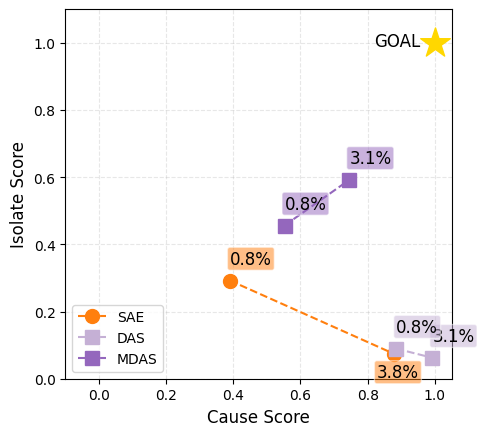

In [ ]:
#@markdown Plotting

import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100


colors = [matplotlib.colors.to_hex(c) for c in plt.cm.tab20.colors]

name_to_color = {
    'SAE_RAND': 'gray',
    'PCA': colors[6],
    'SAE': colors[2],
    'RLAP': colors[4],
    'DBM': colors[1],
    'MDBM': colors[0],
    'DAS': colors[9],
    'MDAS': colors[8],
}

name_to_marker = {
    'SAE_RAND': 'o--',
    'PCA': 'o--',
    'SAE': 'o--',
    'RLAP': '^--',
    'DBM': 's--',
    'MDBM': 's--',
    'DAS': 's--',
    'MDAS': 's--',
}

for n, x in method_to_data.items():
  sorted_dim = sorted(x, key=lambda i: float(i[:-1]))
  p = plt.plot([x[k]['cause'] for k in sorted_dim],
               [x[k]['isolate'] for k in sorted_dim], name_to_marker[n], label=n, markersize=10,
               c=name_to_color[n])
  for k in sorted(x, key=lambda s: x[s]['disentangle'], reverse=True):
    c = p[-1].get_color()
    offset = (0, 0.05)
    # Shift text boxes to avoid overlaps.
    if n == 'SAE' and k == '3.8%':
      offset = (0.05, -0.07)
    plt.annotate(k, (x[k]['cause'] - offset[0], x[k]['isolate'] + offset[1]), size=12,
                 bbox=dict(boxstyle='round,pad=0.15', fc=c, ec='white', alpha=0.5))
plt.scatter(1, 1, s=500, marker='*', color='gold', zorder=3)
plt.annotate('GOAL', (1.0-0.18, 1.0 - 0.01), size=12)
plt.gca().set_aspect('equal')
plt.xlim(-0.1, 1.05)
plt.ylim(-0.0, 1.1)
plt.grid(alpha=0.3, linestyle='--')
plt.legend(loc = 'lower left', prop={'size': 10})
plt.xlabel('Cause Score', fontsize=12)
_ = plt.ylabel('Isolate Score', fontsize=12)